## 데이터 전처리

In [1]:
!pip install eli5
!pip install imblearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 216 kB 2.1 MB/s 
     |████████████████████████████████| 133 kB 29.5 MB/s 
  Created wheel for eli5: filename=eli5-0.13.0-py2.py3-none-any.whl size=107748 sha256=ac47691603725f3be4a0ee28b465620a865ab1853ea80b8e1adf36f9f9e90911
  Stored in directory: /root/.cache/pip/wheels/cc/3c/96/3ead31a8e6c20fc0f1a707fde2e05d49a80b1b4b30096573be
Successfully built eli5
  Attempting uninstall: jinja2
    Found existing installation: Jinja2 2.11.3
    Uninstalling Jinja2-2.11.3:
      Successfully uninstalled Jinja2-2.11.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
flask 1.1.4 requires Jinja2<3.0,>=2.10.1, but you have jinja2 3.1.2 which is incompatible.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheel

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.inspection import permutation_importance
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

import eli5
from eli5.sklearn import PermutationImportance

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from imblearn.over_sampling import RandomOverSampler, SMOTE, BorderlineSMOTE, ADASYN
from collections import Counter

from sklearn import tree
import graphviz 

from sklearn.model_selection import GridSearchCV

import xgboost
import lightgbm as lgb

import warnings
warnings.filterwarnings('ignore')

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
songs = pd.read_csv('/content/gdrive/My Drive/stats/songs_normalize.csv')
songs.head()

,artist,song,duration_ms,explicit,year,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,genre
0,Britney Spears,Oops!...I Did It Again,211160,False,2000,77,0.751,0.834,1,-5.444,0,0.0437,0.3000,0.000018,0.3550,0.894,95.053,pop
1,blink-182,All The Small Things,167066,False,1999,79,0.434,0.897,0,-4.918,1,0.0488,0.0103,0.000000,0.6120,0.684,148.726,"rock, pop"
2,Faith Hill,Breathe,250546,False,1999,66,0.529,0.496,7,-9.007,1,0.0290,0.1730,0.000000,0.2510,0.278,136.859,"pop, country"
3,Bon Jovi,It's My Life,224493,False,2000,78,0.551,0.913,0,-4.063,0,0.0466,0.0263,0.000013,0.3470,0.544,119.992,"rock, metal"
4,*NSYNC,Bye Bye Bye,200560,False,2000,65,0.614,0.928,8,-4.806,0,0.0516,0.0408,0.001040,0.0845,0.879,172.656,pop


In [4]:
songs.shape

(2000, 18)

In [5]:
# 장르 원핫 인코딩
def onehot_genre(df):
  genres = [] # 전체 장르가 담긴 리스트
  for i, genre in enumerate(df.genre):
    df.genre[i] = genre.split(', ') # 장르 split
    genres.extend(df.genre[i])
  
  genres = pd.Series(genres)

  print("장르 종류:", genres.unique())

  oh_df = pd.DataFrame([], columns = genres.unique())

  for idx, gnr in enumerate(df.genre):
    input = []
    for g in genres.unique():
      if g in gnr:
        input.append(1)
      else:
        input.append(0)
    oh_df.loc[idx] = input
  
  return oh_df, genres.value_counts()

In [6]:
oh_genre, genre_values = onehot_genre(songs)
oh_genre

장르 종류: ['pop' 'rock' 'country' 'metal' 'hip hop' 'R&B' 'Dance/Electronic'
 'Folk/Acoustic' 'easy listening' 'latin' 'blues' 'set()'
 'World/Traditional' 'jazz' 'classical']


,pop,rock,country,metal,hip hop,R&B,Dance/Electronic,Folk/Acoustic,easy listening,latin,blues,set(),World/Traditional,jazz,classical
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0
3,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1996,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1997,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0
1998,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [7]:
oh_songs = pd.concat([songs, oh_genre], axis=1)
oh_songs.head()

,artist,song,duration_ms,explicit,year,popularity,danceability,energy,key,loudness,...,R&B,Dance/Electronic,Folk/Acoustic,easy listening,latin,blues,set(),World/Traditional,jazz,classical
0,Britney Spears,Oops!...I Did It Again,211160,False,2000,77,0.751,0.834,1,-5.444,...,0,0,0,0,0,0,0,0,0,0
1,blink-182,All The Small Things,167066,False,1999,79,0.434,0.897,0,-4.918,...,0,0,0,0,0,0,0,0,0,0
2,Faith Hill,Breathe,250546,False,1999,66,0.529,0.496,7,-9.007,...,0,0,0,0,0,0,0,0,0,0
3,Bon Jovi,It's My Life,224493,False,2000,78,0.551,0.913,0,-4.063,...,0,0,0,0,0,0,0,0,0,0
4,*NSYNC,Bye Bye Bye,200560,False,2000,65,0.614,0.928,8,-4.806,...,0,0,0,0,0,0,0,0,0,0


In [8]:
oh_songs.columns

Index(['artist', 'song', 'duration_ms', 'explicit', 'year', 'popularity',
       'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'genre', 'pop', 'rock', 'country', 'metal', 'hip hop', 'R&B',
       'Dance/Electronic', 'Folk/Acoustic', 'easy listening', 'latin', 'blues',
       'set()', 'World/Traditional', 'jazz', 'classical'],
      dtype='object')

In [9]:
genre_values

pop                  1633
hip hop               778
R&B                   452
Dance/Electronic      390
rock                  234
metal                  66
latin                  64
set()                  22
country                21
Folk/Acoustic          20
World/Traditional      10
easy listening          7
blues                   4
jazz                    2
classical               1
dtype: int64

In [10]:
oh_songs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 33 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   artist             2000 non-null   object 
 1   song               2000 non-null   object 
 2   duration_ms        2000 non-null   int64  
 3   explicit           2000 non-null   bool   
 4   year               2000 non-null   int64  
 5   popularity         2000 non-null   int64  
 6   danceability       2000 non-null   float64
 7   energy             2000 non-null   float64
 8   key                2000 non-null   int64  
 9   loudness           2000 non-null   float64
 10  mode               2000 non-null   int64  
 11  speechiness        2000 non-null   float64
 12  acousticness       2000 non-null   float64
 13  instrumentalness   2000 non-null   float64
 14  liveness           2000 non-null   float64
 15  valence            2000 non-null   float64
 16  tempo              2000 

Bool 형식인 Explicit 변수 Label encoding

In [11]:
encoder = LabelEncoder()
oh_songs.explicit = encoder.fit_transform(oh_songs.explicit)

## EDA

### 장르별 상자그림

In [12]:
def feature_box_each(df):
  genres = ['pop', 'hip hop', 'R&B', 'Dance/Electronic']

  plt.figure(figsize=(32, 15))

  # Popularity
  plt.subplot(3, 4, 1)
  popularity = []
  for genre in genres:
    popularity.append(df[df[genre]==1]['popularity'].values)
  plt.boxplot(popularity)
  plt.xticks([1, 2, 3, 4], genres)
  plt.title('Popularity')

  # Duration(ms)
  plt.subplot(3, 4, 2)
  popularity = []
  for genre in genres:
    popularity.append(df[df[genre]==1]['duration_ms'].values)
  plt.boxplot(popularity)
  plt.xticks([1, 2, 3, 4], genres)
  plt.title('Duration(ms)')

  # Danceability
  plt.subplot(3, 4, 3)
  popularity = []
  for genre in genres:
    popularity.append(df[df[genre]==1]['danceability'].values)
  plt.boxplot(popularity)
  plt.xticks([1, 2, 3, 4], genres)
  plt.title('Danceability')

  # Energy
  plt.subplot(3, 4, 4)
  popularity = []
  for genre in genres:
    popularity.append(df[df[genre]==1]['energy'].values)
  plt.boxplot(popularity)
  plt.xticks([1, 2, 3, 4], genres)
  plt.title('Energy')

  # Key
  plt.subplot(3, 4, 5)
  popularity = []
  for genre in genres:
    popularity.append(df[df[genre]==1]['key'].values)
  plt.boxplot(popularity)
  plt.xticks([1, 2, 3, 4], genres)
  plt.title('Key')

  # Loudness
  plt.subplot(3, 4, 6)
  popularity = []
  for genre in genres:
    popularity.append(df[df[genre]==1]['loudness'].values)
  plt.boxplot(popularity)
  plt.xticks([1, 2, 3, 4], genres)
  plt.title('Loudness')

  # Speechiness
  plt.subplot(3, 4, 7)
  popularity = []
  for genre in genres:
    popularity.append(df[df[genre]==1]['speechiness'].values)
  plt.boxplot(popularity)
  plt.xticks([1, 2, 3, 4], genres)
  plt.title('Speechiness')

  # Acousticness
  plt.subplot(3, 4, 8)
  popularity = []
  for genre in genres:
    popularity.append(df[df[genre]==1]['acousticness'].values)
  plt.boxplot(popularity)
  plt.xticks([1, 2, 3, 4], genres)
  plt.title('Acousticness')

  # Liveness
  plt.subplot(3, 4, 9)
  popularity = []
  for genre in genres:
    popularity.append(df[df[genre]==1]['liveness'].values)
  plt.boxplot(popularity)
  plt.xticks([1, 2, 3, 4], genres)
  plt.title('Liveness')

  # Valence
  plt.subplot(3, 4, 10)
  popularity = []
  for genre in genres:
    popularity.append(df[df[genre]==1]['valence'].values)
  plt.boxplot(popularity)
  plt.xticks([1, 2, 3, 4], genres)
  plt.title('Valence')

  # Tempo
  plt.subplot(3, 4, 11)
  popularity = []
  for genre in genres:
    popularity.append(df[df[genre]==1]['tempo'].values)
  plt.boxplot(popularity)
  plt.xticks([1, 2, 3, 4], genres)
  plt.title('Tempo')

  plt.show()

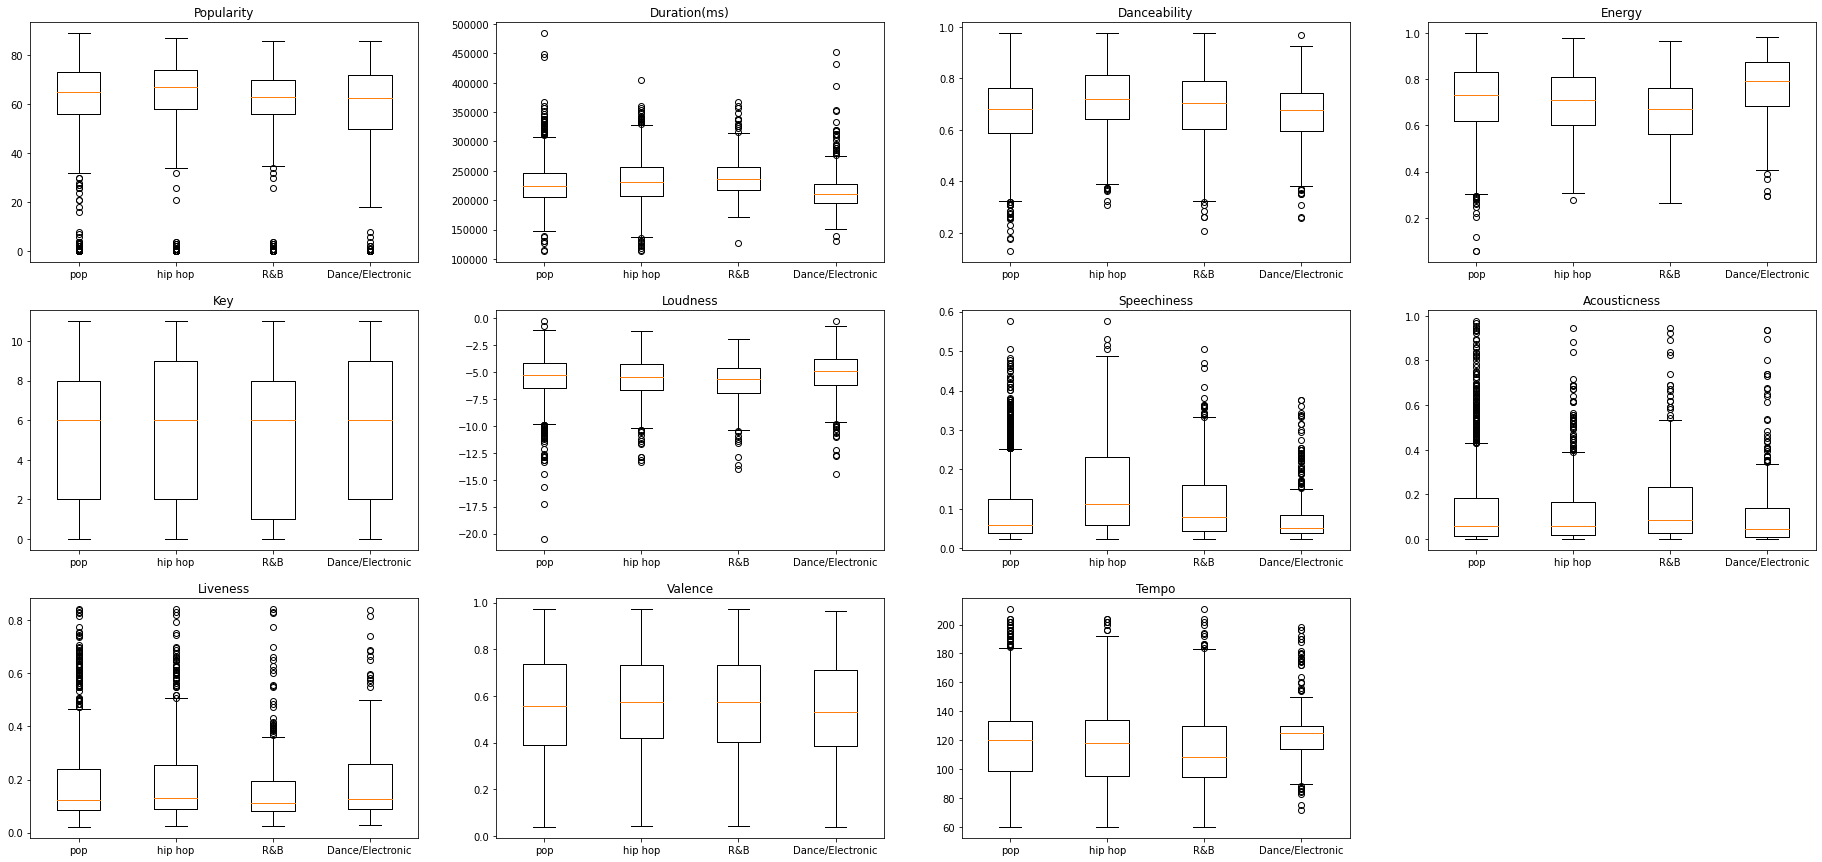

In [13]:
feature_box_each(oh_songs)

### 피처별 분포도

In [14]:
def feature_dist(df, alpha=0.5):

  """
    Get Distribution of each features
    Continuous Features : ['duration_ms', 'popularity','danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 
                           'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']
    Categorical Features : ['explicit', 'year']
    
  """

  plt.figure(figsize=(32, 20))

  target = df.columns[-1]

  # Popularity
  plt.subplot(4, 4, 1)
  sns.histplot(x='popularity', data=df, hue=target, kde=True, alpha=0.5, hue_order=[1, 0], legend=False)
  plt.title('Popularity')
  plt.legend(labels=['Not '+target, target])

  # Duration(ms)
  plt.subplot(4, 4, 2)
  sns.histplot(x='duration_ms', data=df, hue=target, kde=True, alpha=0.5, hue_order=[1, 0], legend=False)
  plt.title('Duration(ms)')
  plt.legend(labels=['Not '+target, target])

  # Danceability
  plt.subplot(4, 4, 3)
  sns.histplot(x='danceability', data=df, hue=target, kde=True, alpha=0.5, hue_order=[1, 0], legend=False)
  plt.title('Danceability')
  plt.legend(labels=['Not '+target, target])

  # Energy
  plt.subplot(4, 4, 4)
  sns.histplot(x='energy', data=df, hue=target, kde=True, alpha=0.5, hue_order=[1, 0], legend=False)
  plt.title('Energy')
  plt.legend(labels=['Not '+target, target])

  # Key
  plt.subplot(4, 4, 5)
  sns.histplot(x='key', data=df, hue=target, kde=True, alpha=0.5, hue_order=[1, 0], legend=False)
  plt.title('Key')
  plt.legend(labels=['Not '+target, target])

  # Loudness
  plt.subplot(4, 4, 6)
  sns.histplot(x='loudness', data=df, hue=target, kde=True, alpha=0.5, hue_order=[1, 0], legend=False)
  plt.title('Loudness')
  plt.legend(labels=['Not '+target, target])

  # Mode
  plt.subplot(4, 4, 7)
  sns.countplot(x='mode', hue=target, data=df, alpha=0.5, hue_order=[1, 0])
  plt.title('Mode')
  plt.legend(labels=[target, 'Not '+target])

  # Speechiness
  plt.subplot(4, 4, 8)
  sns.histplot(x='speechiness', data=df, hue=target, kde=True, alpha=0.5, hue_order=[1, 0], legend=False)
  plt.title('Speechiness')
  plt.legend(labels=['Not '+target, target])

  # Acousticness
  plt.subplot(4, 4, 9)
  sns.histplot(x='acousticness', data=df, hue=target, kde=True, alpha=0.5, hue_order=[1, 0], legend=False)
  plt.title('Acousticness')
  plt.legend(labels=['Not '+target, target])

  # Instrumentalness
  plt.subplot(4, 4, 10)
  plt.hist(df[df[target]==1]['instrumentalness'], alpha=alpha, label=target)
  plt.hist(df[df[target]==0]['instrumentalness'], alpha=alpha, label='Not '+target)
  plt.title('Instrumentalness')
  plt.legend()

  # Liveness
  plt.subplot(4, 4, 11)
  sns.histplot(x='liveness', data=df, hue=target, kde=True, alpha=0.5, hue_order=[1, 0], legend=False)
  plt.title('Liveness')
  plt.legend(labels=['Not '+target, target])

  # Valence
  plt.subplot(4, 4, 12)
  sns.histplot(x='valence', data=df, hue=target, kde=True, alpha=0.5, hue_order=[1, 0], legend=False)
  plt.title('Valence')
  plt.legend(labels=['Not '+target, target])

  # Tempo
  plt.subplot(4, 4, 13)
  sns.histplot(x='tempo', data=df, hue=target, kde=True, alpha=0.5, hue_order=[1, 0], legend=False)
  plt.title('Tempo')
  plt.legend(labels=['Not '+target, target])

  # Explicit
  plt.subplot(4, 4, 14)
  sns.countplot(x='explicit', hue=target, data=df, alpha=0.5, hue_order=[1, 0])
  plt.title('Explicit')
  plt.legend(labels=[target, 'Not '+target])

  # Year
  plt.subplot(4, 4, 15)
  sns.countplot(x='year', hue=target, data=df, alpha=0.5, hue_order=[1, 0])
  plt.title('Year')
  plt.legend(labels=[target, 'Not '+target])
  plt.xticks(rotation=45)


  plt.show()

In [15]:
def feature_box(df, alpha=0.5):

  """
    Get Box plot of each features
    Continuous Features : ['duration_ms', 'popularity','danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 
                           'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']
    Categorical Features : ['explicit', 'year']
    
  """

  plt.figure(figsize=(32, 20))

  target = df.columns[-1]

  # Popularity
  plt.subplot(4, 4, 1)
  sns.boxplot(data=df, x=target, y='popularity', hue=target, hue_order=[1, 0], orient='v')
  plt.title('Popularity')

  # Duration(ms)
  plt.subplot(4, 4, 2)
  sns.boxplot(data=df, x=target, y='duration_ms', hue=target, hue_order=[1, 0], orient='v')
  plt.title('Duration(ms)')
  
  # Danceability
  plt.subplot(4, 4, 3)
  sns.boxplot(data=df, x=target, y='danceability', hue=target, hue_order=[1, 0], orient='v')
  plt.title('Danceability')

  # Energy
  plt.subplot(4, 4, 4)
  sns.boxplot(data=df, x=target, y='energy', hue=target, hue_order=[1, 0], orient='v')
  plt.title('Energy')

  # Key
  plt.subplot(4, 4, 5)
  sns.boxplot(data=df, x=target, y='key', hue=target, hue_order=[1, 0], orient='v')
  plt.title('Key')

  # Loudness
  plt.subplot(4, 4, 6)
  sns.boxplot(data=df, x=target, y='loudness', hue=target, hue_order=[1, 0], orient='v')
  plt.title('Loudness')

  # Mode
  plt.subplot(4, 4, 7)
  sns.countplot(x='mode', hue=target, data=df, alpha=0.5, hue_order=[1, 0])
  plt.title('Mode')
  plt.legend(labels=[target, 'Not '+target])

  # Speechiness
  plt.subplot(4, 4, 8)
  sns.boxplot(data=df, x=target, y='speechiness', hue=target, hue_order=[1, 0], orient='v')
  plt.title('Speechiness')

  # Acousticness
  plt.subplot(4, 4, 9)
  sns.boxplot(data=df, x=target, y='acousticness', hue=target, hue_order=[1, 0], orient='v')
  plt.title('Acousticness')

  # Instrumentalness
  plt.subplot(4, 4, 10)
  plt.hist(df[df[target]==1]['instrumentalness'], alpha=alpha, label=target)
  plt.hist(df[df[target]==0]['instrumentalness'], alpha=alpha, label='Not '+target)
  plt.title('Instrumentalness')
  plt.legend()

  # Liveness
  plt.subplot(4, 4, 11)
  sns.boxplot(data=df, x=target, y='liveness', hue=target, hue_order=[1, 0], orient='v')
  plt.title('Liveness')

  # Valence
  plt.subplot(4, 4, 12)
  sns.boxplot(data=df, x=target, y='valence', hue=target, hue_order=[1, 0], orient='v')
  plt.title('Valence')

  # Tempo
  plt.subplot(4, 4, 13)
  sns.boxplot(data=df, x=target, y='tempo', hue=target, hue_order=[1, 0], orient='v')
  plt.title('Tempo')

  # Explicit
  plt.subplot(4, 4, 14)
  sns.countplot(x='explicit', hue=target, data=df, alpha=0.5, hue_order=[1, 0])
  plt.title('Explicit')
  plt.legend(labels=[target, 'Not '+target])

  # Year
  plt.subplot(4, 4, 15)
  sns.countplot(x='year', hue=target, data=df, alpha=0.5, hue_order=[1, 0])
  plt.title('Year')
  plt.legend(labels=[target, 'Not '+target])
  plt.xticks(rotation=45)


  plt.show()

In [16]:
# Pop
songs_Pop = oh_songs[['artist', 'song', 'duration_ms', 'explicit', 'year', 'popularity', 'danceability', \
                   'energy', 'key', 'loudness', 'mode', 'speechiness','acousticness', 'instrumentalness', \
                   'liveness', 'valence', 'tempo', 'pop']]
# HipHop
songs_HipHop = oh_songs[['artist', 'song', 'duration_ms', 'explicit', 'year', 'popularity', 'danceability', \
                   'energy', 'key', 'loudness', 'mode', 'speechiness','acousticness', 'instrumentalness', \
                   'liveness', 'valence', 'tempo', 'hip hop']]
# R&B
songs_RnB = oh_songs[['artist', 'song', 'duration_ms', 'explicit', 'year', 'popularity', 'danceability', \
                   'energy', 'key', 'loudness', 'mode', 'speechiness','acousticness', 'instrumentalness', \
                   'liveness', 'valence', 'tempo', 'R&B']]
# Dance / Electronic
songs_DanceElectronic = oh_songs[['artist', 'song', 'duration_ms', 'explicit', 'year', 'popularity', 'danceability', \
                   'energy', 'key', 'loudness', 'mode', 'speechiness','acousticness', 'instrumentalness', \
                   'liveness', 'valence', 'tempo', 'Dance/Electronic']]

#### Pop

In [17]:
songs_Pop.describe()

,duration_ms,explicit,year,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
count,2000.000000,2000.000000,2000.00000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,228748.124500,0.275500,2009.49400,59.872500,0.667438,0.720366,5.378000,-5.512434,0.553500,0.103568,0.128955,0.015226,0.181216,0.551690,120.122558
std,39136.569008,0.446878,5.85996,21.335577,0.140416,0.152745,3.615059,1.933482,0.497254,0.096159,0.173346,0.087771,0.140669,0.220864,26.967112
min,113000.000000,0.000000,1998.00000,0.000000,0.129000,0.054900,0.000000,-20.514000,0.000000,0.023200,0.000019,0.000000,0.021500,0.038100,60.019000
25%,203580.000000,0.000000,2004.00000,56.000000,0.581000,0.622000,2.000000,-6.490250,0.000000,0.039600,0.014000,0.000000,0.088100,0.386750,98.985750
50%,223279.500000,0.000000,2010.00000,65.500000,0.676000,0.736000,6.000000,-5.285000,1.000000,0.059850,0.055700,0.000000,0.124000,0.557500,120.021500
75%,248133.000000,1.000000,2015.00000,73.000000,0.764000,0.839000,8.000000,-4.167750,1.000000,0.129000,0.176250,0.000068,0.241000,0.730000,134.265500
max,484146.000000,1.000000,2020.00000,89.000000,0.975000,0.999000,11.000000,-0.276000,1.000000,0.576000,0.976000,0.985000,0.853000,0.973000,210.851000


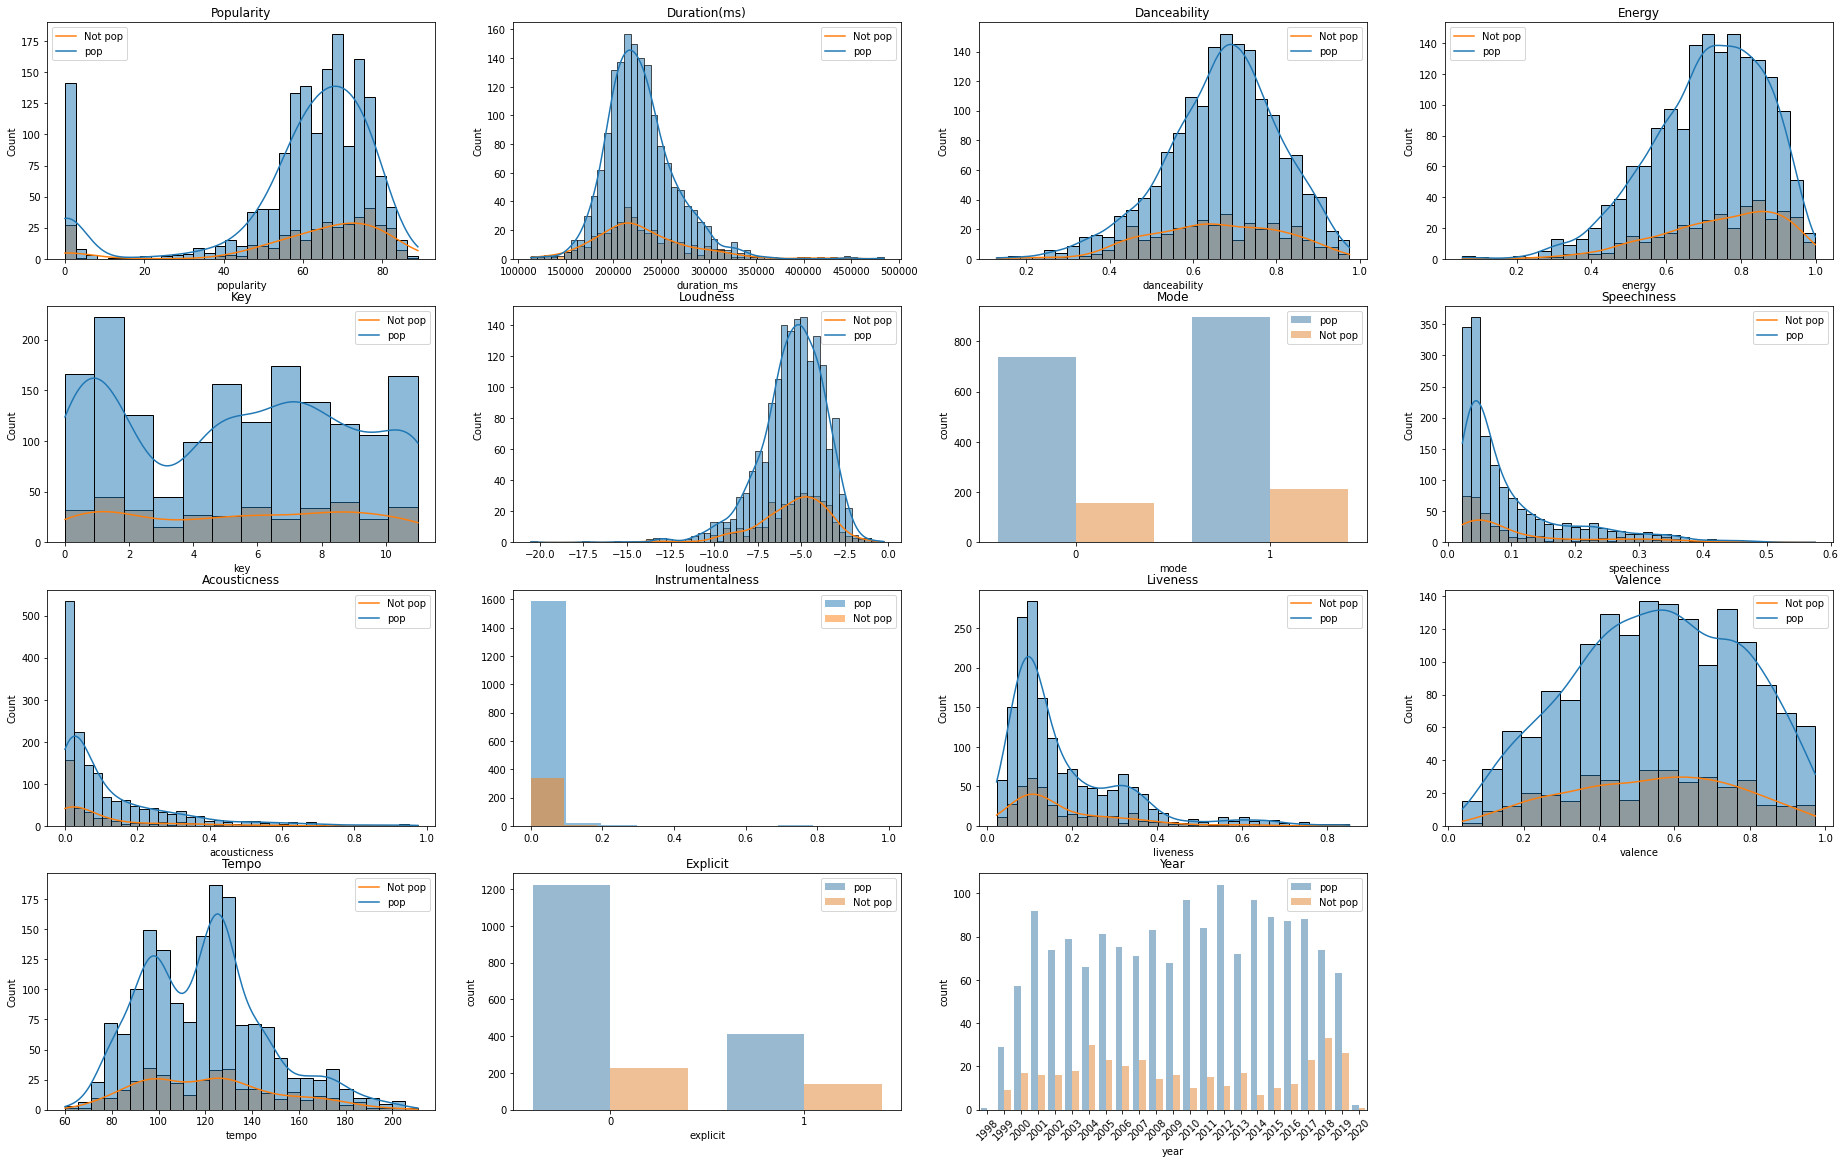

In [18]:
feature_dist(songs_Pop)

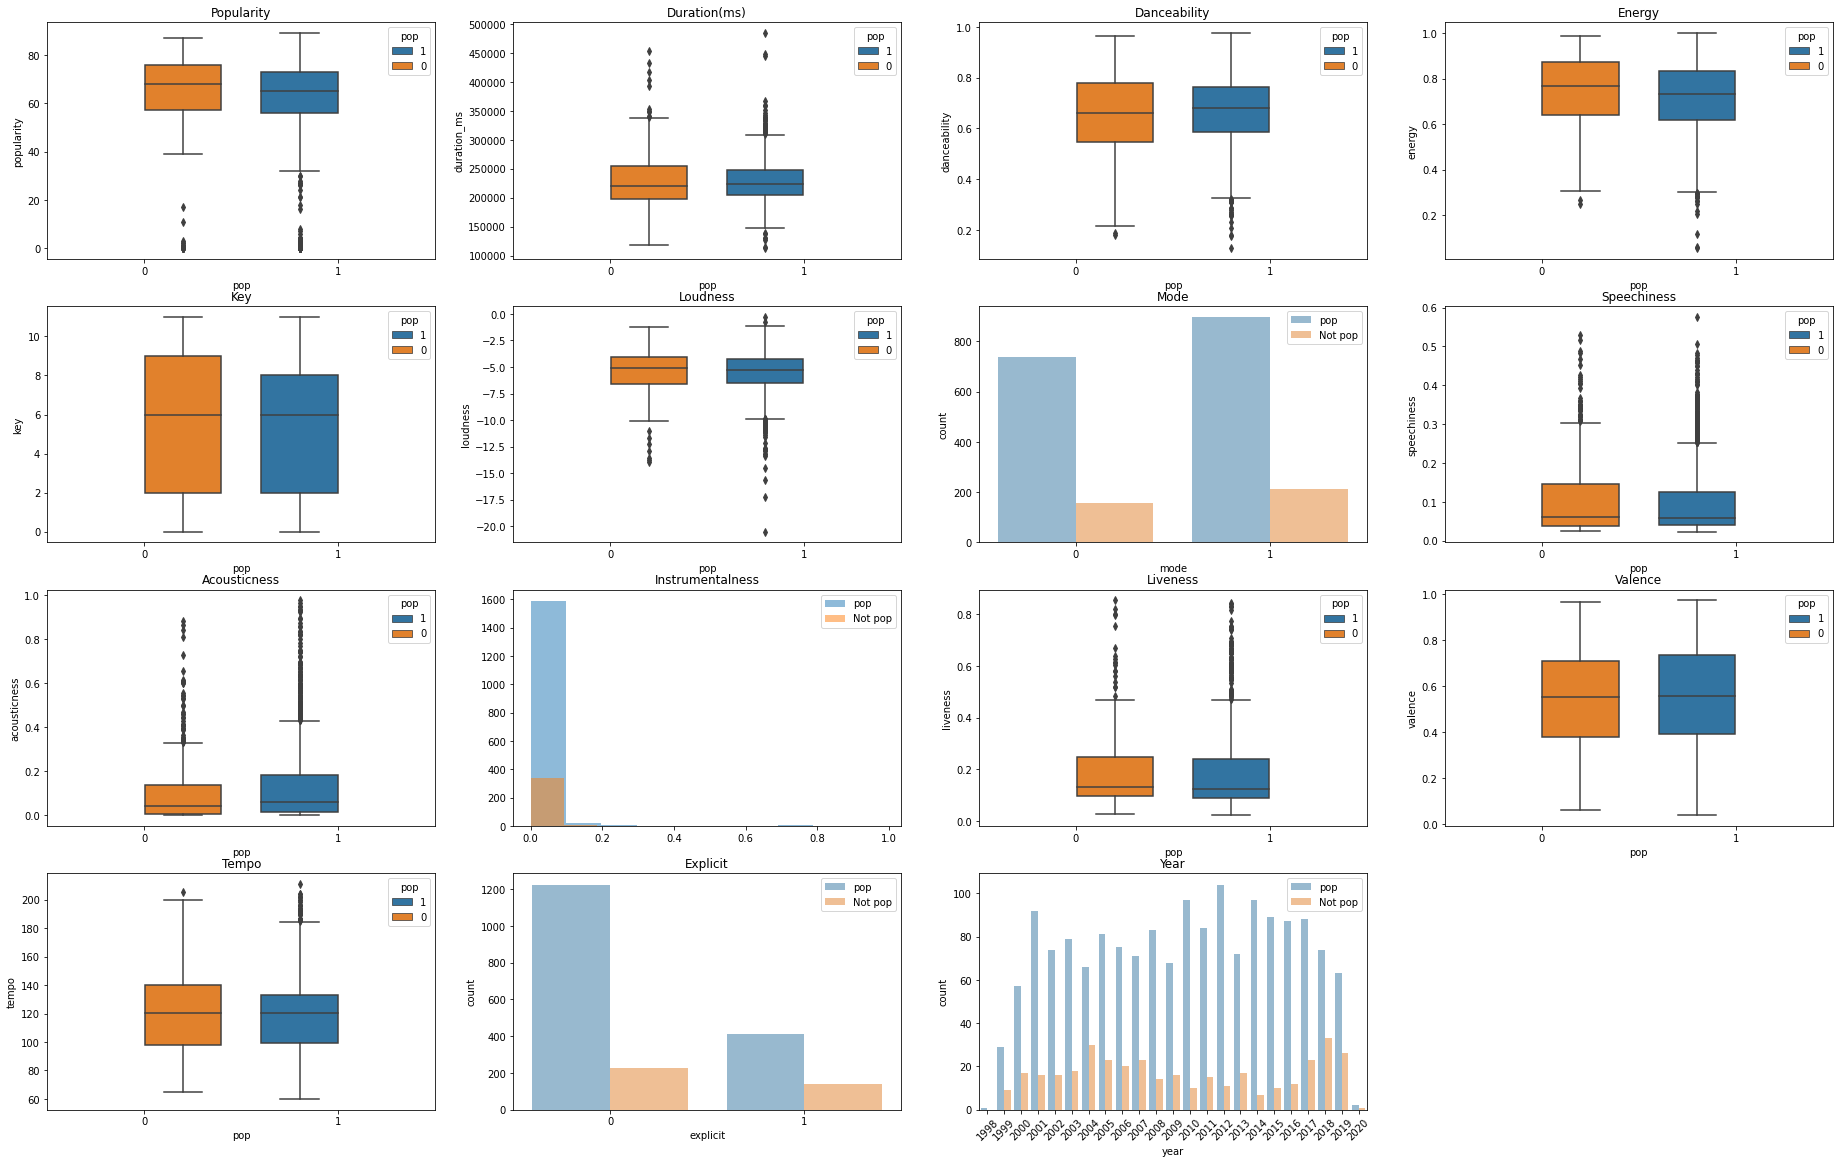

In [19]:
feature_box(songs_Pop)

#### HipHop

In [20]:
songs_HipHop.describe()

,duration_ms,explicit,year,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
count,2000.000000,2000.000000,2000.00000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,228748.124500,0.275500,2009.49400,59.872500,0.667438,0.720366,5.378000,-5.512434,0.553500,0.103568,0.128955,0.015226,0.181216,0.551690,120.122558
std,39136.569008,0.446878,5.85996,21.335577,0.140416,0.152745,3.615059,1.933482,0.497254,0.096159,0.173346,0.087771,0.140669,0.220864,26.967112
min,113000.000000,0.000000,1998.00000,0.000000,0.129000,0.054900,0.000000,-20.514000,0.000000,0.023200,0.000019,0.000000,0.021500,0.038100,60.019000
25%,203580.000000,0.000000,2004.00000,56.000000,0.581000,0.622000,2.000000,-6.490250,0.000000,0.039600,0.014000,0.000000,0.088100,0.386750,98.985750
50%,223279.500000,0.000000,2010.00000,65.500000,0.676000,0.736000,6.000000,-5.285000,1.000000,0.059850,0.055700,0.000000,0.124000,0.557500,120.021500
75%,248133.000000,1.000000,2015.00000,73.000000,0.764000,0.839000,8.000000,-4.167750,1.000000,0.129000,0.176250,0.000068,0.241000,0.730000,134.265500
max,484146.000000,1.000000,2020.00000,89.000000,0.975000,0.999000,11.000000,-0.276000,1.000000,0.576000,0.976000,0.985000,0.853000,0.973000,210.851000


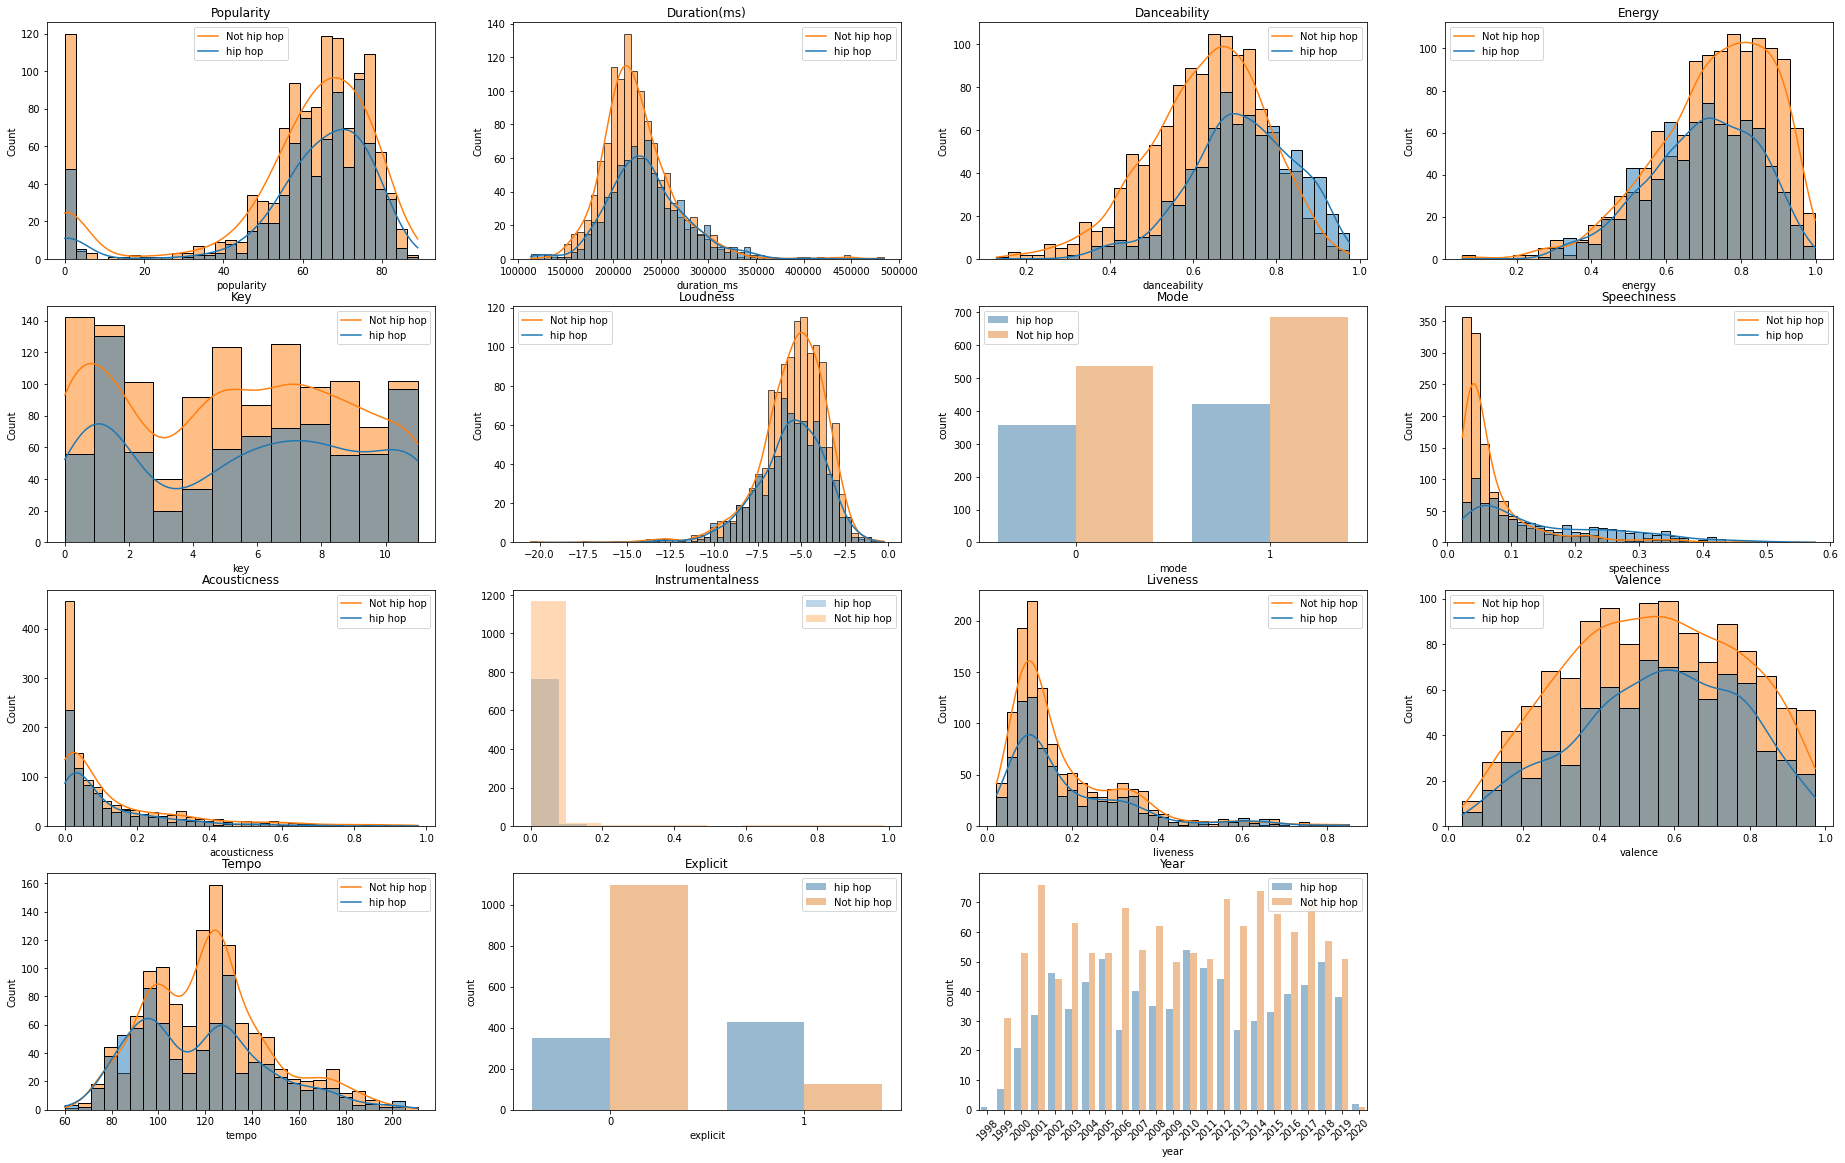

In [21]:
feature_dist(songs_HipHop, alpha=0.3)

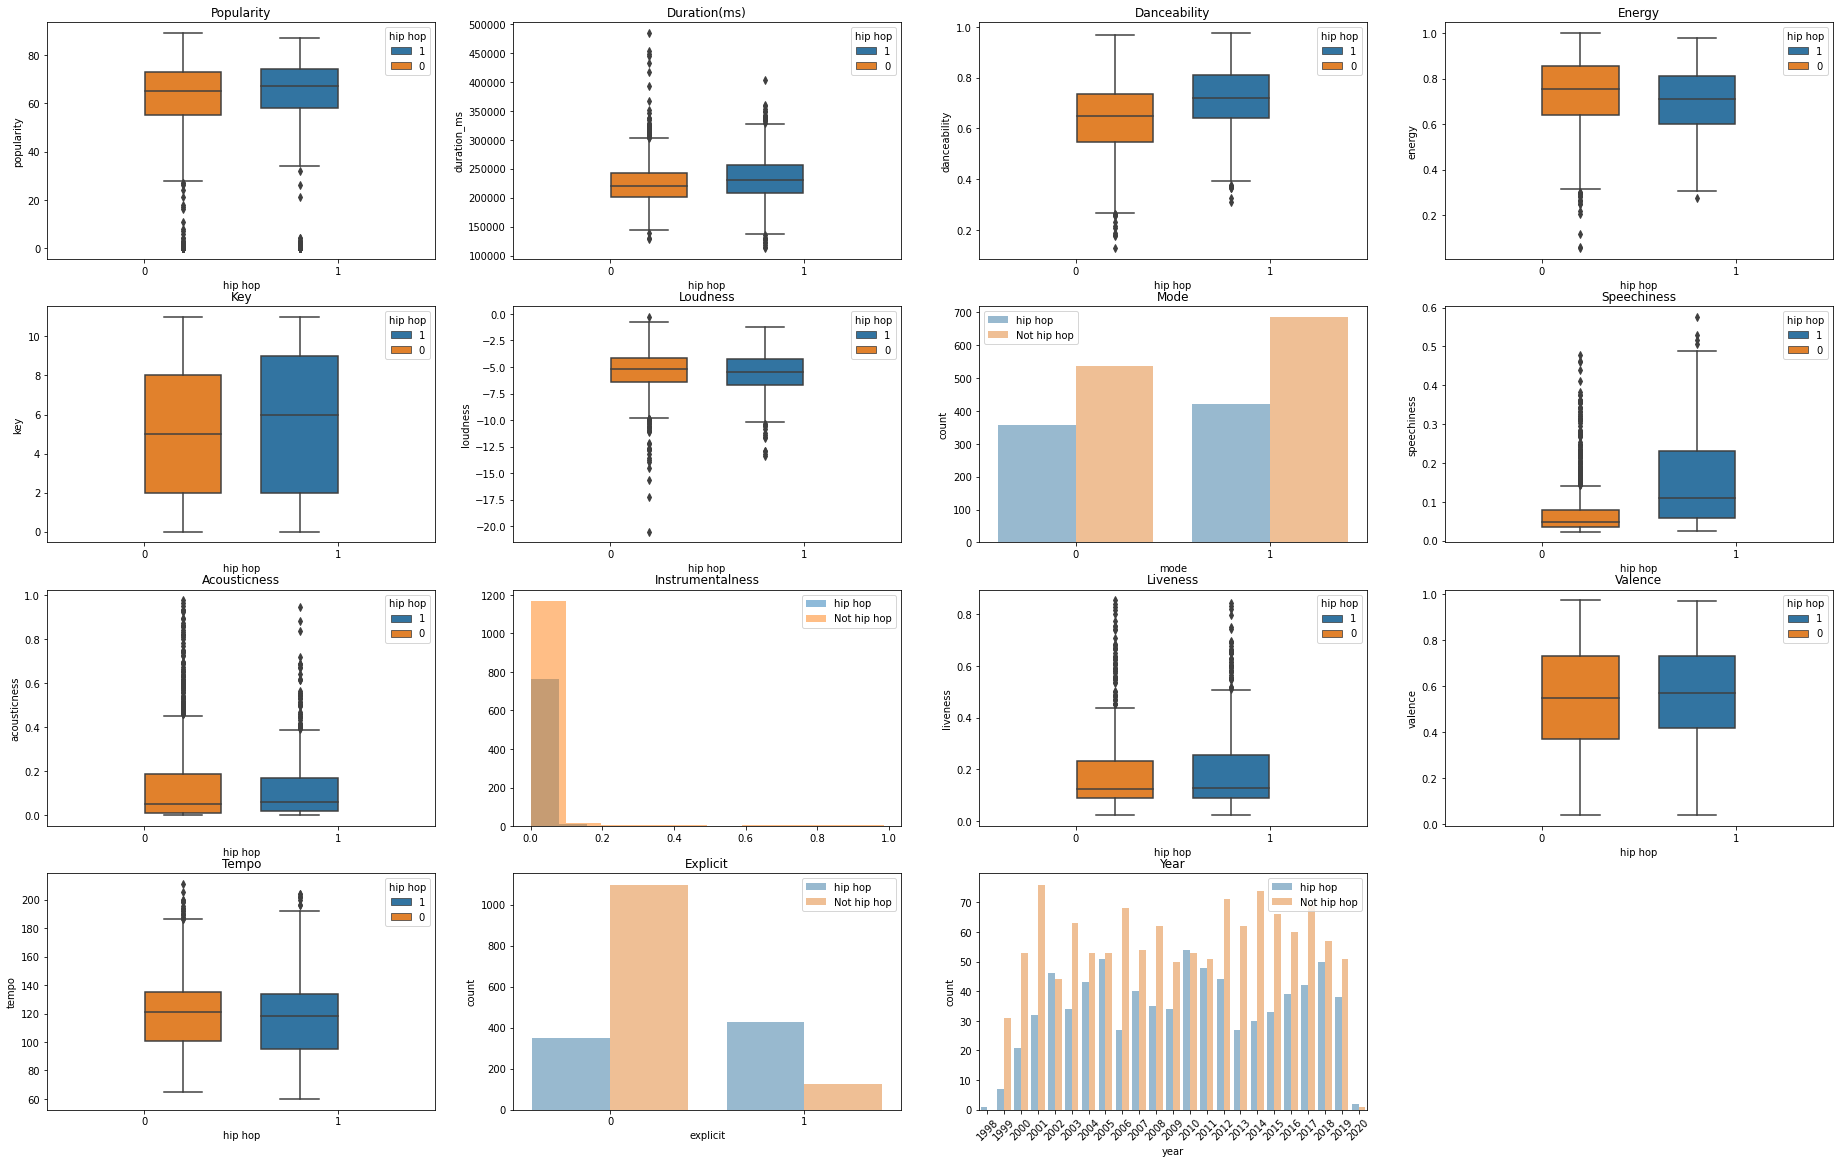

In [22]:
feature_box(songs_HipHop)

#### R&B

In [23]:
songs_RnB.describe()

,duration_ms,explicit,year,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
count,2000.000000,2000.000000,2000.00000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,228748.124500,0.275500,2009.49400,59.872500,0.667438,0.720366,5.378000,-5.512434,0.553500,0.103568,0.128955,0.015226,0.181216,0.551690,120.122558
std,39136.569008,0.446878,5.85996,21.335577,0.140416,0.152745,3.615059,1.933482,0.497254,0.096159,0.173346,0.087771,0.140669,0.220864,26.967112
min,113000.000000,0.000000,1998.00000,0.000000,0.129000,0.054900,0.000000,-20.514000,0.000000,0.023200,0.000019,0.000000,0.021500,0.038100,60.019000
25%,203580.000000,0.000000,2004.00000,56.000000,0.581000,0.622000,2.000000,-6.490250,0.000000,0.039600,0.014000,0.000000,0.088100,0.386750,98.985750
50%,223279.500000,0.000000,2010.00000,65.500000,0.676000,0.736000,6.000000,-5.285000,1.000000,0.059850,0.055700,0.000000,0.124000,0.557500,120.021500
75%,248133.000000,1.000000,2015.00000,73.000000,0.764000,0.839000,8.000000,-4.167750,1.000000,0.129000,0.176250,0.000068,0.241000,0.730000,134.265500
max,484146.000000,1.000000,2020.00000,89.000000,0.975000,0.999000,11.000000,-0.276000,1.000000,0.576000,0.976000,0.985000,0.853000,0.973000,210.851000


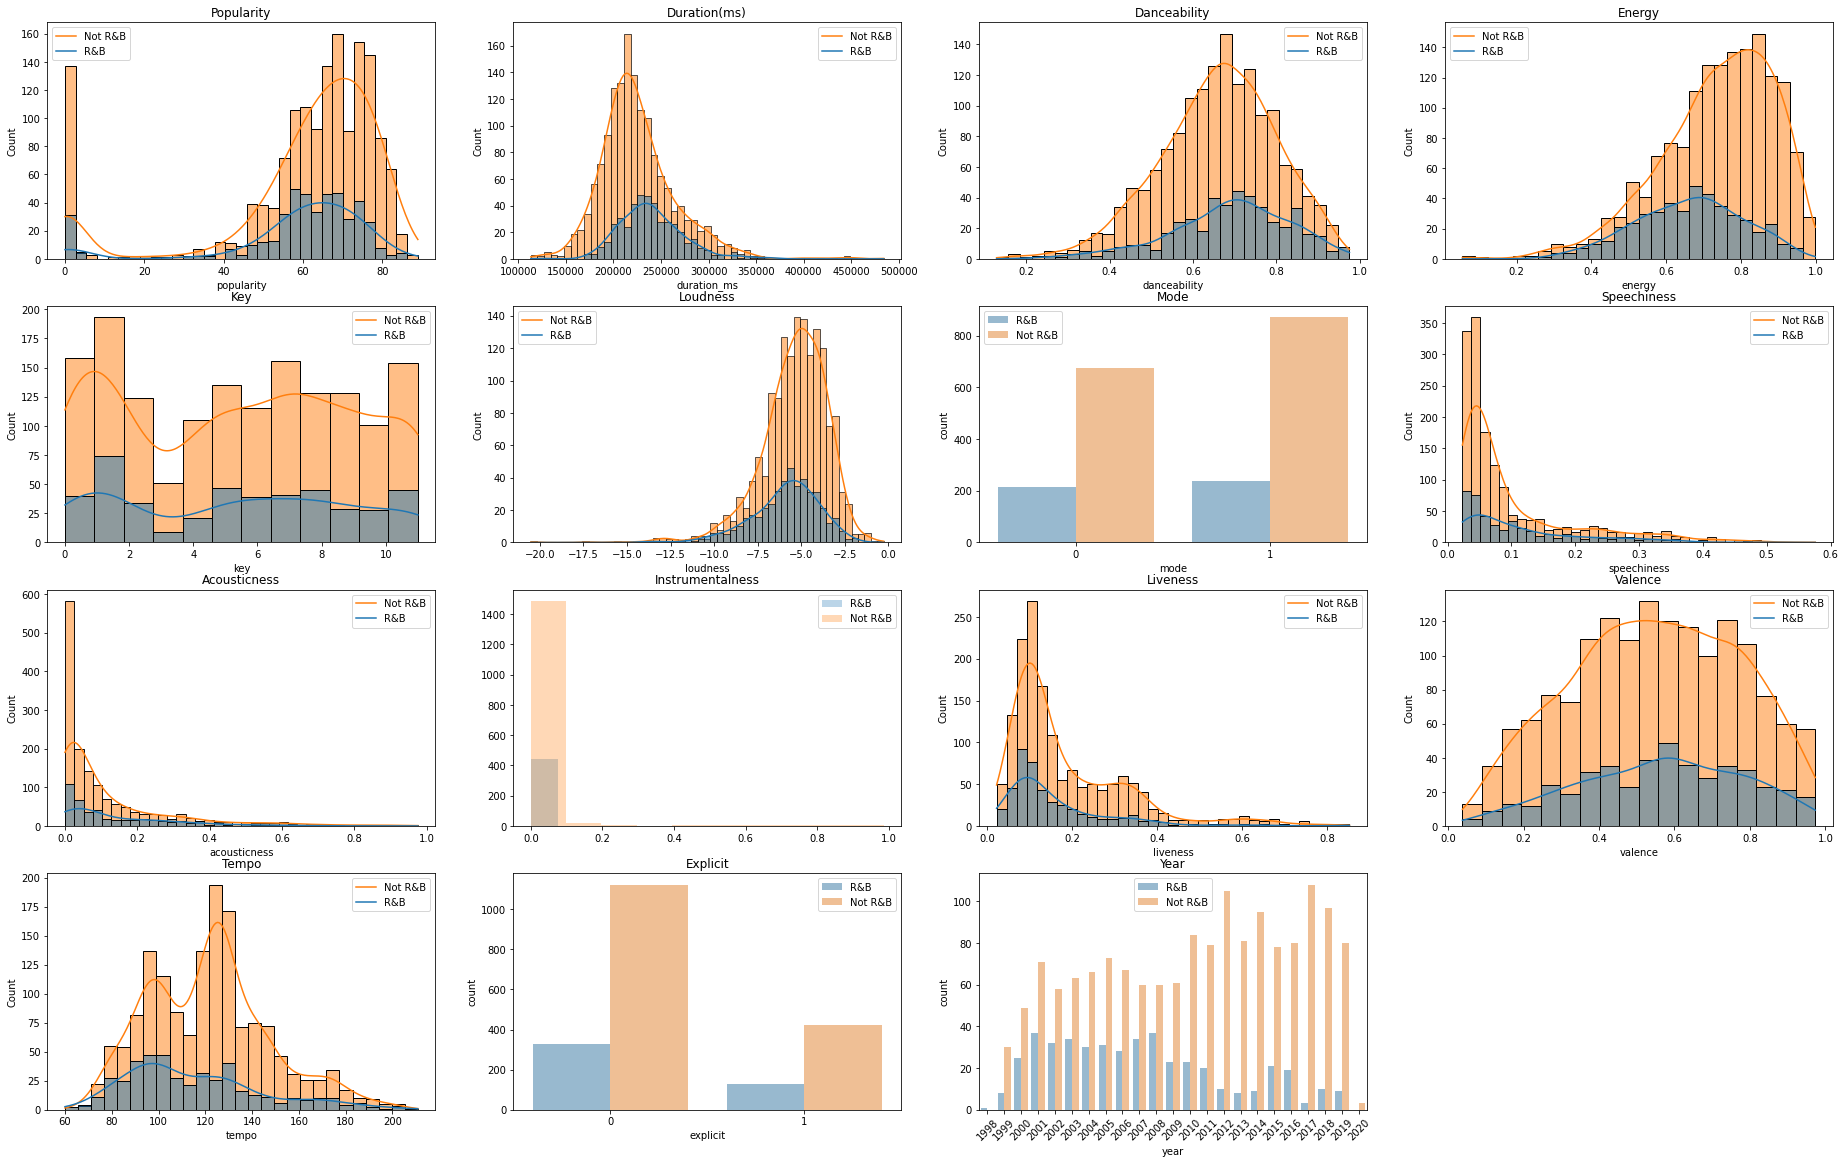

In [24]:
feature_dist(songs_RnB, alpha=0.3)

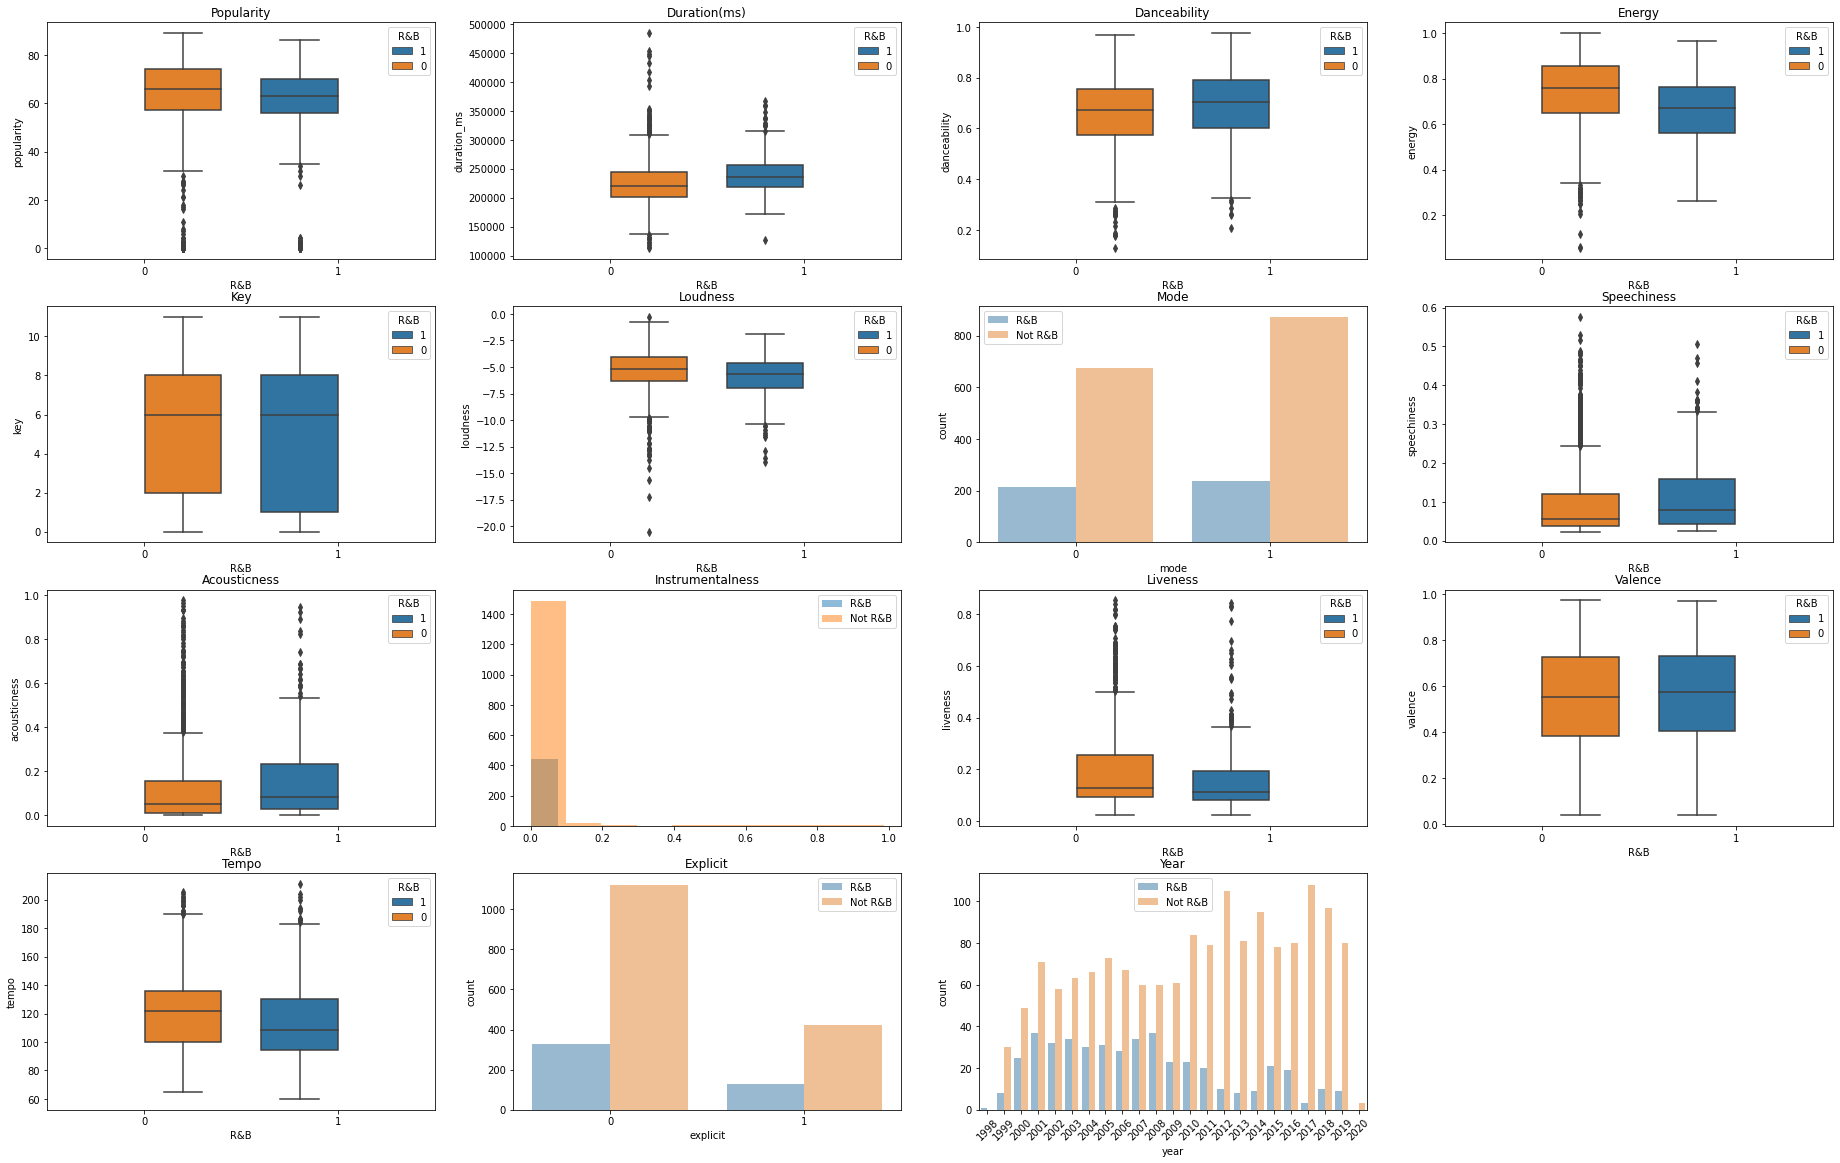

In [25]:
feature_box(songs_RnB)

#### Dance/Electronic

In [26]:
songs_DanceElectronic.describe()

,duration_ms,explicit,year,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
count,2000.000000,2000.000000,2000.00000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,228748.124500,0.275500,2009.49400,59.872500,0.667438,0.720366,5.378000,-5.512434,0.553500,0.103568,0.128955,0.015226,0.181216,0.551690,120.122558
std,39136.569008,0.446878,5.85996,21.335577,0.140416,0.152745,3.615059,1.933482,0.497254,0.096159,0.173346,0.087771,0.140669,0.220864,26.967112
min,113000.000000,0.000000,1998.00000,0.000000,0.129000,0.054900,0.000000,-20.514000,0.000000,0.023200,0.000019,0.000000,0.021500,0.038100,60.019000
25%,203580.000000,0.000000,2004.00000,56.000000,0.581000,0.622000,2.000000,-6.490250,0.000000,0.039600,0.014000,0.000000,0.088100,0.386750,98.985750
50%,223279.500000,0.000000,2010.00000,65.500000,0.676000,0.736000,6.000000,-5.285000,1.000000,0.059850,0.055700,0.000000,0.124000,0.557500,120.021500
75%,248133.000000,1.000000,2015.00000,73.000000,0.764000,0.839000,8.000000,-4.167750,1.000000,0.129000,0.176250,0.000068,0.241000,0.730000,134.265500
max,484146.000000,1.000000,2020.00000,89.000000,0.975000,0.999000,11.000000,-0.276000,1.000000,0.576000,0.976000,0.985000,0.853000,0.973000,210.851000


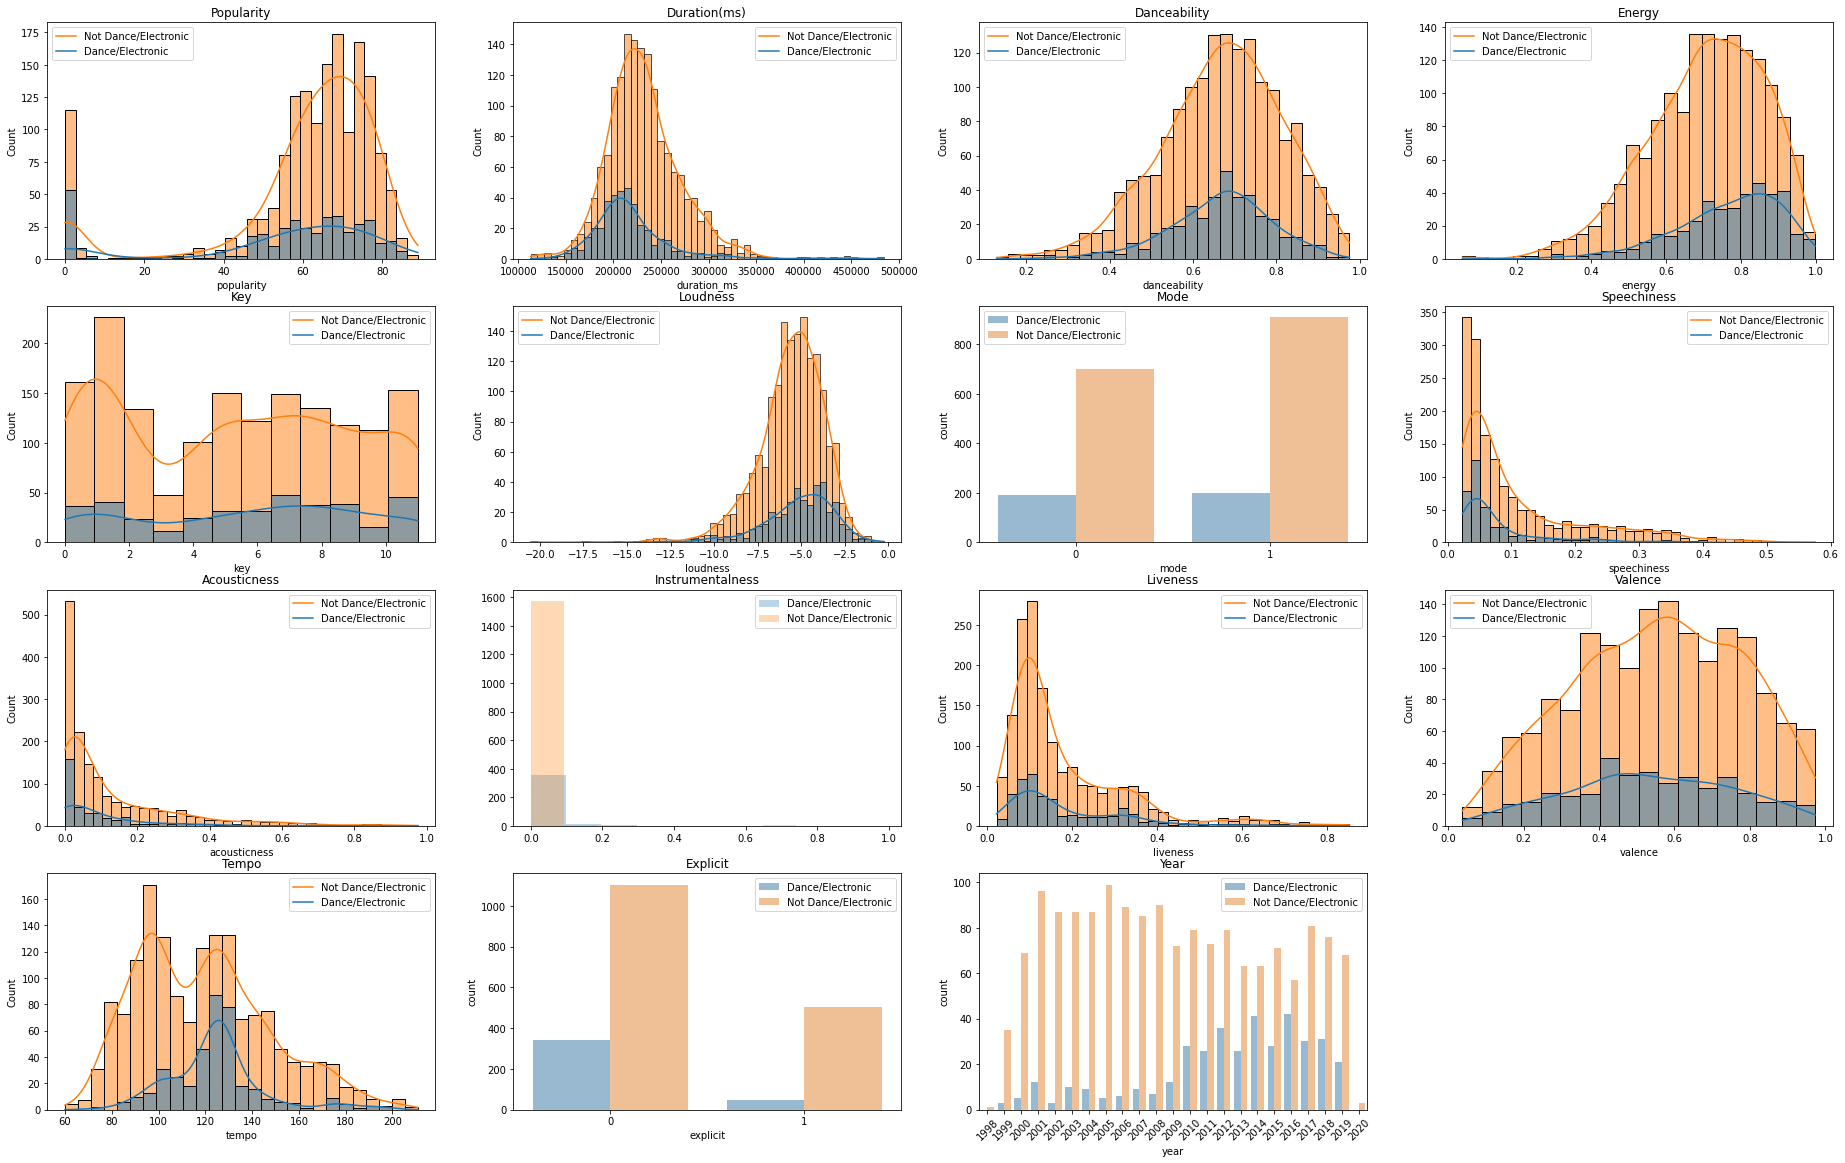

In [27]:
feature_dist(songs_DanceElectronic, alpha=0.3)

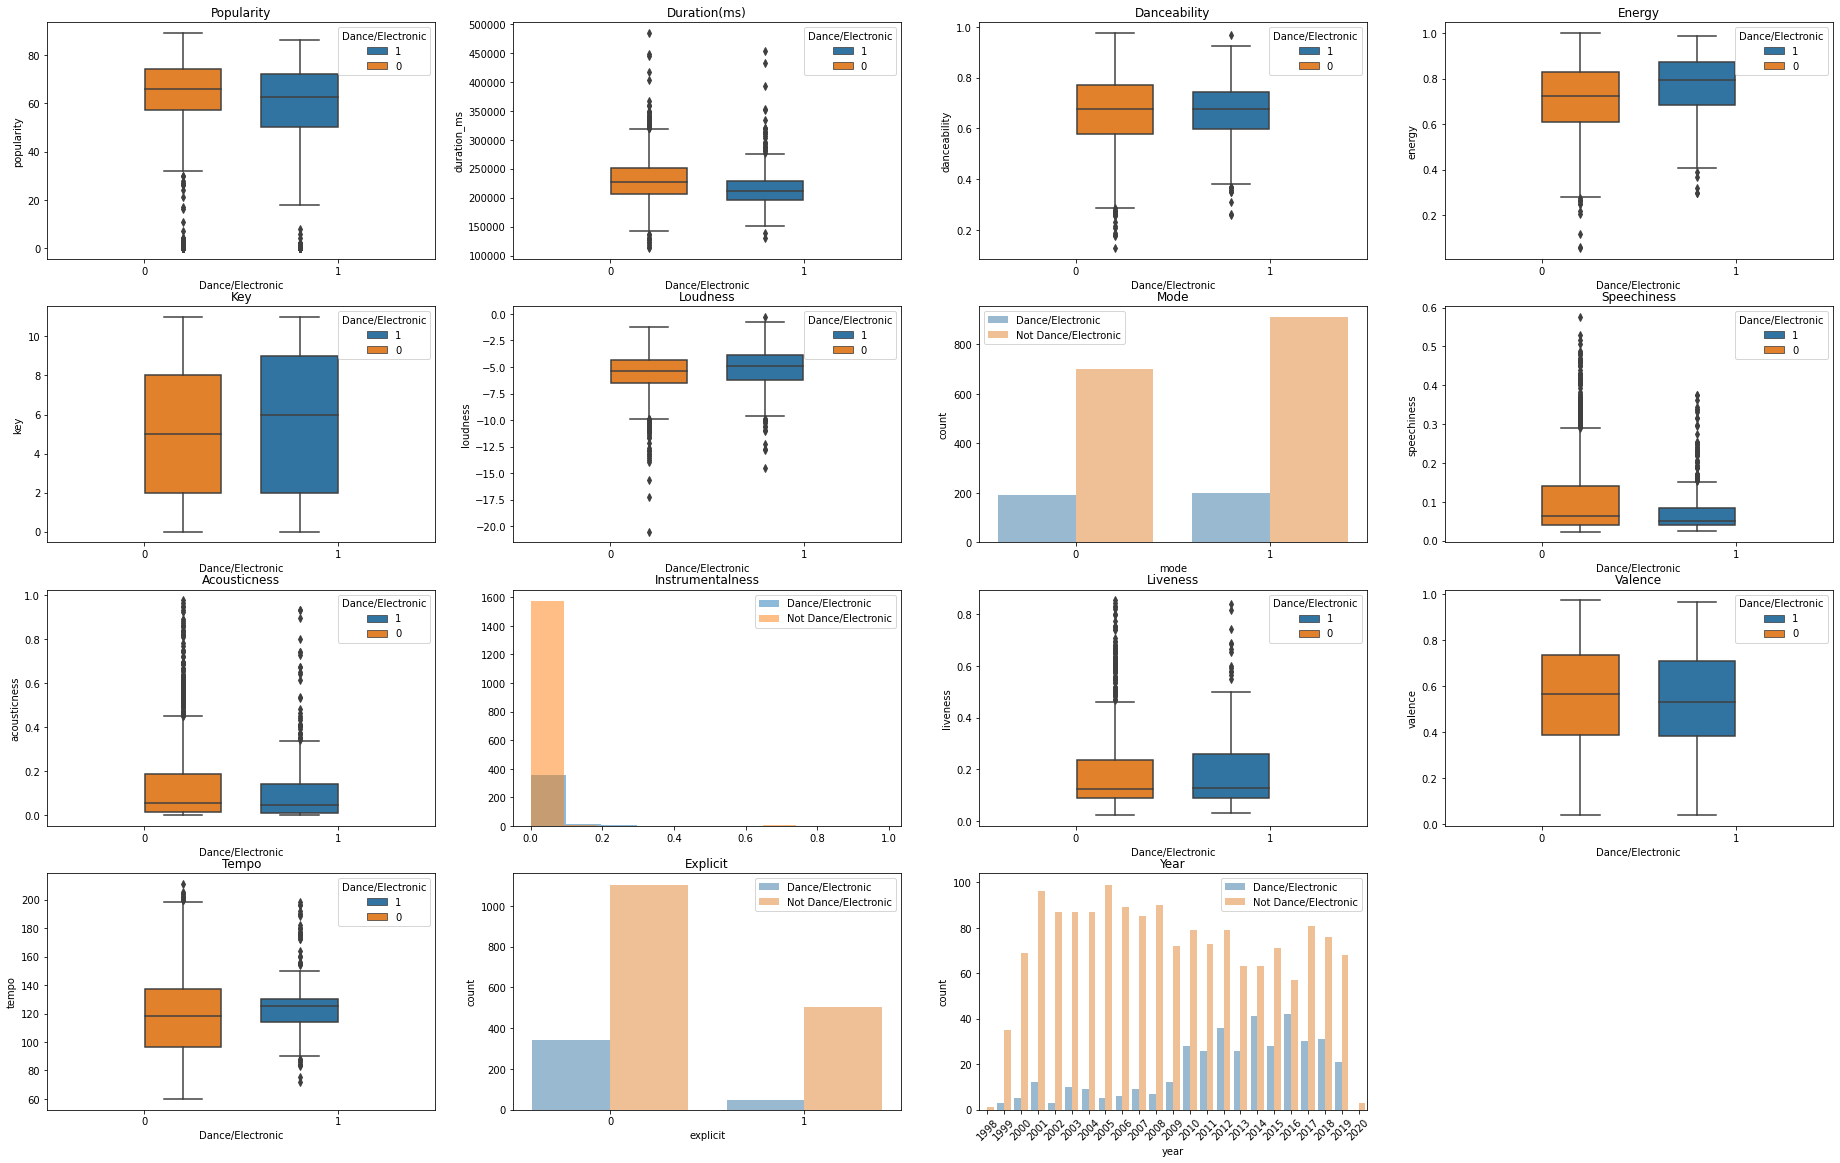

In [28]:
feature_box(songs_DanceElectronic)

## 변수 선택

### Permutation Importance

In [29]:
oh_songs.columns

Index(['artist', 'song', 'duration_ms', 'explicit', 'year', 'popularity',
       'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'genre', 'pop', 'rock', 'country', 'metal', 'hip hop', 'R&B',
       'Dance/Electronic', 'Folk/Acoustic', 'easy listening', 'latin', 'blues',
       'set()', 'World/Traditional', 'jazz', 'classical'],
      dtype='object')

In [30]:
songs_Pop.columns.drop(['artist','song'])

Index(['duration_ms', 'explicit', 'year', 'popularity', 'danceability',
       'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo', 'pop'],
      dtype='object')

In [31]:
songs_Pop.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   artist            2000 non-null   object 
 1   song              2000 non-null   object 
 2   duration_ms       2000 non-null   int64  
 3   explicit          2000 non-null   int64  
 4   year              2000 non-null   int64  
 5   popularity        2000 non-null   int64  
 6   danceability      2000 non-null   float64
 7   energy            2000 non-null   float64
 8   key               2000 non-null   int64  
 9   loudness          2000 non-null   float64
 10  mode              2000 non-null   int64  
 11  speechiness       2000 non-null   float64
 12  acousticness      2000 non-null   float64
 13  instrumentalness  2000 non-null   float64
 14  liveness          2000 non-null   float64
 15  valence           2000 non-null   float64
 16  tempo             2000 non-null   float64


In [32]:
all_cols = ['duration_ms', 'explicit', 'year', 'popularity',\
       'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',\
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']

In [33]:
def PM_randomforest_eli5(df, n_iter=100):

  # Train test split
  X_train, X_test, y_train, y_test = train_test_split(df[df.columns[:-1].drop(['artist','song'])], df[df.columns[-1]].astype(int), test_size=0.3, random_state=42)

  # Random Forest
  rf_model = RandomForestClassifier(max_depth=5, random_state=10)
  rf_model.fit(X_train, y_train)

  # Metrics
  y_pred_train = rf_model.predict(X_train)
  y_pred = rf_model.predict(X_test)
  train_acc = accuracy_score(y_train, y_pred_train)
  test_acc = accuracy_score(y_test, y_pred)
  train_precision = precision_score(y_train, y_pred_train)
  test_precision = precision_score(y_test, y_pred)
  train_recall = recall_score(y_train, y_pred_train)
  test_recall = recall_score(y_test, y_pred)
  train_f1 = f1_score(y_train, y_pred_train)
  test_f1 = f1_score(y_test, y_pred)

  print("[Accuracy]", "Train:", np.round(train_acc, 4), "| Test:", np.round(test_acc, 4))
  print("[Precision]", "Train:", np.round(train_precision, 4), "| Test:", np.round(test_precision, 4))
  print("[Recall]", "Train:", np.round(train_recall, 4), "| Test:", np.round(test_recall, 4))
  print("[F1 Score]", "Train:", np.round(train_f1, 4), "| Test:", np.round(test_f1, 4))

  # Permutation Importance
  perm = PermutationImportance(rf_model, scoring = "f1", n_iter=n_iter).fit(X_test, y_test)
  return perm, X_test

In [34]:
def test_randomforest(df, cols):
  # Train test split
  X_train, X_test, y_train, y_test = train_test_split(df[cols], df[df.columns[-1]].astype(int), test_size=0.3, random_state=42)

  # Random Forest
  rf_model = RandomForestClassifier(max_depth=5, random_state=10)
  rf_model.fit(X_train, y_train)

  # Metrics
  y_pred_train = rf_model.predict(X_train)
  y_pred = rf_model.predict(X_test)
  train_acc = accuracy_score(y_train, y_pred_train)
  test_acc = accuracy_score(y_test, y_pred)
  train_precision = precision_score(y_train, y_pred_train)
  test_precision = precision_score(y_test, y_pred)
  train_recall = recall_score(y_train, y_pred_train)
  test_recall = recall_score(y_test, y_pred)
  train_f1 = f1_score(y_train, y_pred_train)
  test_f1 = f1_score(y_test, y_pred)

  print("[Accuracy]", "Train:", np.round(train_acc, 4), "| Test:", np.round(test_acc, 4))
  print("[Precision]", "Train:", np.round(train_precision, 4), "| Test:", np.round(test_precision, 4))
  print("[Recall]", "Train:", np.round(train_recall, 4), "| Test:", np.round(test_recall, 4))
  print("[F1 Score]", "Train:", np.round(train_f1, 4), "| Test:", np.round(test_f1, 4))

  return rf_model

#### Pop

In [35]:
perm, X_test = PM_randomforest_eli5(songs_Pop)
eli5.show_weights(perm, top = 80, feature_names = X_test.columns.tolist())

[Accuracy] Train: 0.8293 | Test: 0.8267
[Precision] Train: 0.8263 | Test: 0.8278
[Recall] Train: 1.0 | Test: 0.998
[F1 Score] Train: 0.9049 | Test: 0.9049


Weight,Feature
0.0002 ± 0.0018,popularity
0.0001 ± 0.0012,acousticness
-0.0001 ± 0.0011,duration_ms
-0.0001 ± 0.0007,energy
-0.0002 ± 0.0008,liveness
-0.0003 ± 0.0009,tempo
-0.0003 ± 0.0008,mode
-0.0004 ± 0.0015,explicit
-0.0005 ± 0.0015,speechiness
-0.0005 ± 0.0011,instrumentalness


In [36]:
test_randomforest(songs_Pop, ['duration_ms', 'explicit', 'year', 'popularity','danceability',\
 'energy', 'speechiness','acousticness', 'instrumentalness'])

[Accuracy] Train: 0.8407 | Test: 0.825
[Precision] Train: 0.836 | Test: 0.8308
[Recall] Train: 1.0 | Test: 0.9899
[F1 Score] Train: 0.9107 | Test: 0.9034


RandomForestClassifier(max_depth=5, random_state=10)

In [37]:
test_randomforest(songs_Pop, ['popularity','acousticness','duration_ms'])

[Accuracy] Train: 0.8257 | Test: 0.8317
[Precision] Train: 0.8233 | Test: 0.8319
[Recall] Train: 1.0 | Test: 0.998
[F1 Score] Train: 0.9031 | Test: 0.9074


RandomForestClassifier(max_depth=5, random_state=10)

#### Hiphop

In [38]:
perm, X_test = PM_randomforest_eli5(songs_HipHop)
eli5.show_weights(perm, top = 80, feature_names = X_test.columns.tolist())

[Accuracy] Train: 0.8286 | Test: 0.775
[Precision] Train: 0.8943 | Test: 0.8333
[Recall] Train: 0.6215 | Test: 0.5668
[F1 Score] Train: 0.7333 | Test: 0.6747


Weight,Feature
0.2037 ± 0.0422,explicit
0.0646 ± 0.0288,speechiness
0.0303 ± 0.0194,danceability
0.0214 ± 0.0152,instrumentalness
0.0141 ± 0.0138,tempo
0.0108 ± 0.0092,loudness
0.0088 ± 0.0084,acousticness
0.0087 ± 0.0161,duration_ms
0.0073 ± 0.0085,year
0.0065 ± 0.0110,energy


In [39]:
test_randomforest(songs_HipHop, ['duration_ms', 'explicit', 'year', 'popularity','danceability','energy', 'key', 
'loudness', 'speechiness','acousticness', 'instrumentalness', 'tempo','valence'])

[Accuracy] Train: 0.8271 | Test: 0.7667
[Precision] Train: 0.8937 | Test: 0.8204
[Recall] Train: 0.6177 | Test: 0.5547
[F1 Score] Train: 0.7305 | Test: 0.6618


RandomForestClassifier(max_depth=5, random_state=10)

#### R&B

In [40]:
perm, X_test = PM_randomforest_eli5(songs_RnB)
eli5.show_weights(perm, top = 80, feature_names = X_test.columns.tolist())

[Accuracy] Train: 0.8079 | Test: 0.7733
[Precision] Train: 0.92 | Test: 0.6471
[Recall] Train: 0.1479 | Test: 0.078
[F1 Score] Train: 0.2548 | Test: 0.1392


Weight,Feature
0.0741 ± 0.0430,year
0.0576 ± 0.0485,energy
0.0426 ± 0.0423,popularity
0.0404 ± 0.0439,acousticness
0.0383 ± 0.0429,duration_ms
0.0340 ± 0.0425,tempo
0.0234 ± 0.0409,speechiness
0.0187 ± 0.0288,valence
0.0181 ± 0.0398,mode
0.0179 ± 0.0302,instrumentalness


In [41]:
test_randomforest(songs_RnB, ['duration_ms', 'year', 'popularity','danceability','energy', 'loudness', 'speechiness',\
 'acousticness', 'tempo'])

[Accuracy] Train: 0.8293 | Test: 0.7717
[Precision] Train: 0.8913 | Test: 0.5588
[Recall] Train: 0.2637 | Test: 0.1348
[F1 Score] Train: 0.4069 | Test: 0.2171


RandomForestClassifier(max_depth=5, random_state=10)

#### Dance/Electronic

In [42]:
perm, X_test = PM_randomforest_eli5(songs_DanceElectronic)
eli5.show_weights(perm, top = 80, feature_names = X_test.columns.tolist())

[Accuracy] Train: 0.8357 | Test: 0.8433
[Precision] Train: 1.0 | Test: 0.8
[Recall] Train: 0.1986 | Test: 0.1165
[F1 Score] Train: 0.3314 | Test: 0.2034


Weight,Feature
0.0964 ± 0.0528,instrumentalness
0.0943 ± 0.0483,tempo
0.0863 ± 0.0563,year
0.0744 ± 0.0447,duration_ms
0.0712 ± 0.0453,energy
0.0624 ± 0.0471,loudness
0.0546 ± 0.0412,speechiness
0.0527 ± 0.0500,popularity
0.0324 ± 0.0381,explicit
0.0203 ± 0.0235,acousticness


In [43]:
test_randomforest(songs_DanceElectronic, ['duration_ms', 'explicit', 'year', 'popularity','danceability','energy', 'loudness', 'speechiness',\
 'instrumentalness', 'tempo'])

[Accuracy] Train: 0.845 | Test: 0.8417
[Precision] Train: 0.9605 | Test: 0.7
[Recall] Train: 0.2544 | Test: 0.1359
[F1 Score] Train: 0.4022 | Test: 0.2276


RandomForestClassifier(max_depth=5, random_state=10)

### MDI

In [44]:
def PM_randomforest_mdi(df, thr=0.03):

  # Train test split
  X_train, X_test, y_train, y_test = train_test_split(df[df.columns[:-1].drop(['artist','song'])], df[df.columns[-1]].astype(int), test_size=0.3, random_state=42)

  # Random Forest
  rf_model = RandomForestClassifier(max_depth=5)
  rf_model.fit(X_train, y_train)

  # Metrics
  y_pred_train = rf_model.predict(X_train)
  y_pred = rf_model.predict(X_test)
  train_acc = accuracy_score(y_train, y_pred_train)
  test_acc = accuracy_score(y_test, y_pred)
  train_precision = precision_score(y_train, y_pred_train)
  test_precision = precision_score(y_test, y_pred)
  train_recall = recall_score(y_train, y_pred_train)
  test_recall = recall_score(y_test, y_pred)
  train_f1 = f1_score(y_train, y_pred_train)
  test_f1 = f1_score(y_test, y_pred)

  print("[Accuracy]", "Train:", np.round(train_acc, 4), "| Test:", np.round(test_acc, 4))
  print("[Precision]", "Train:", np.round(train_precision, 4), "| Test:", np.round(test_precision, 4))
  print("[Recall]", "Train:", np.round(train_recall, 4), "| Test:", np.round(test_recall, 4))
  print("[F1 Score]", "Train:", np.round(train_f1, 4), "| Test:", np.round(test_f1, 4))

  # Permutation Importance
  importances = rf_model.feature_importances_
  mdi_importances = pd.Series(importances, index=df.columns[:-1].drop(['artist','song'])).sort_values(ascending=False)
  idx = mdi_importances[mdi_importances>thr].index
  return mdi_importances, idx

#### Pop

In [45]:
mdi, idx = PM_randomforest_mdi(songs_Pop)
print("\n",mdi)

[Accuracy] Train: 0.83 | Test: 0.8233
[Precision] Train: 0.8269 | Test: 0.8261
[Recall] Train: 1.0 | Test: 0.996
[F1 Score] Train: 0.9053 | Test: 0.9031

 popularity          0.110157
energy              0.105477
duration_ms         0.093679
danceability        0.089827
year                0.085667
speechiness         0.082579
acousticness        0.081397
instrumentalness    0.073421
tempo               0.071171
loudness            0.060540
liveness            0.047771
explicit            0.038115
valence             0.037274
key                 0.018308
mode                0.004616
dtype: float64


In [46]:
test_randomforest(songs_Pop, idx)

[Accuracy] Train: 0.8329 | Test: 0.83
[Precision] Train: 0.8293 | Test: 0.8316
[Recall] Train: 1.0 | Test: 0.996
[F1 Score] Train: 0.9067 | Test: 0.9064


RandomForestClassifier(max_depth=5, random_state=10)

#### Hiphop

In [47]:
mdi, idx = PM_randomforest_mdi(songs_HipHop, thr=0.01)
print("\n",mdi)

[Accuracy] Train: 0.8279 | Test: 0.7633
[Precision] Train: 0.8984 | Test: 0.8182
[Recall] Train: 0.6158 | Test: 0.5466
[F1 Score] Train: 0.7307 | Test: 0.6553

 explicit            0.320609
speechiness         0.222023
danceability        0.095523
tempo               0.054428
duration_ms         0.047996
instrumentalness    0.041430
acousticness        0.037789
energy              0.037198
loudness            0.028405
liveness            0.025508
popularity          0.025106
year                0.024432
valence             0.023442
key                 0.012246
mode                0.003866
dtype: float64


In [48]:
test_randomforest(songs_HipHop, idx)

[Accuracy] Train: 0.825 | Test: 0.7667
[Precision] Train: 0.8907 | Test: 0.8204
[Recall] Train: 0.6139 | Test: 0.5547
[F1 Score] Train: 0.7269 | Test: 0.6618


RandomForestClassifier(max_depth=5, random_state=10)

#### R&B

In [49]:
mdi, idx = PM_randomforest_mdi(songs_RnB)
print("\n",mdi)

[Accuracy] Train: 0.8079 | Test: 0.7717
[Precision] Train: 0.9565 | Test: 0.75
[Recall] Train: 0.1415 | Test: 0.0426
[F1 Score] Train: 0.2465 | Test: 0.0805

 year                0.171117
energy              0.159630
duration_ms         0.109397
acousticness        0.099304
tempo               0.071708
speechiness         0.069998
liveness            0.053991
loudness            0.050024
danceability        0.049785
popularity          0.047470
valence             0.040502
instrumentalness    0.036902
key                 0.020742
mode                0.011417
explicit            0.008014
dtype: float64


In [50]:
test_randomforest(songs_RnB, idx)

[Accuracy] Train: 0.8243 | Test: 0.7817
[Precision] Train: 0.9577 | Test: 0.7083
[Recall] Train: 0.2186 | Test: 0.1206
[F1 Score] Train: 0.356 | Test: 0.2061


RandomForestClassifier(max_depth=5, random_state=10)

#### Dance/Electronic

In [51]:
mdi, idx = PM_randomforest_mdi(songs_DanceElectronic)
print("\n",mdi)

[Accuracy] Train: 0.8336 | Test: 0.8383
[Precision] Train: 0.9821 | Test: 0.75
[Recall] Train: 0.1916 | Test: 0.0874
[F1 Score] Train: 0.3207 | Test: 0.1565

 year                0.179740
tempo               0.132375
instrumentalness    0.123867
energy              0.081109
loudness            0.079788
duration_ms         0.071393
popularity          0.062330
speechiness         0.051089
explicit            0.050595
acousticness        0.040277
valence             0.039766
liveness            0.036719
danceability        0.029758
key                 0.017782
mode                0.003412
dtype: float64


In [52]:
test_randomforest(songs_DanceElectronic, idx)

[Accuracy] Train: 0.8457 | Test: 0.8417
[Precision] Train: 1.0 | Test: 0.7222
[Recall] Train: 0.2474 | Test: 0.1262
[F1 Score] Train: 0.3966 | Test: 0.2149


RandomForestClassifier(max_depth=5, random_state=10)

## 파라미터 튜닝

In [53]:
class classification():
  def __init__(self, df_idx, params, cv=5, pr=True, oversampling=None, positive_ratio=1.0):
    self.songs = pd.read_csv('/content/gdrive/My Drive/stats/songs_onehot.csv', index_col=0)

    songs_Pop = self.songs[['duration_ms', 'explicit', 'year', 'popularity','danceability',\
                            'energy', 'speechiness','acousticness', 'instrumentalness', 'pop']]
    songs_HipHop = self.songs[['duration_ms', 'explicit', 'year', 'popularity','danceability','energy', 'key', \
                               'loudness', 'speechiness','acousticness', 'instrumentalness', 'tempo', 'hip hop']]
    songs_RnB = self.songs[['duration_ms', 'year', 'popularity','danceability','energy', 'loudness', 'speechiness',\
                            'acousticness', 'tempo', 'R&B']]
    songs_DE = self.songs[['duration_ms', 'explicit', 'year', 'popularity','danceability','energy', 'loudness', 'speechiness',\
                           'instrumentalness', 'tempo', 'Dance/Electronic']]
    
    self.datas = [songs_Pop, songs_HipHop, songs_RnB, songs_DE]
    self.data_names = ['Pop','HipHop','R&B','Dance/Electornic']
    self.df_idx = df_idx
    self.data = self.datas[self.df_idx]
    self.data, self.data_test = train_test_split(self.data, test_size=0.2, random_state = 42)

    # Params
    self.metrics = ['precision','recall','f1']
    self.pr = pr
    self.oversampling = oversampling
    self.positive_ratio = positive_ratio
    self.params = params
    self.cv = cv
  
  """
      Classification Models
  """
  def rf_model(self):

    print("\nGenre :", self.data_names[self.df_idx])
    print("Over Sampling :", self.oversampling)

    X_train, X_test, y_train, y_test = self.data_split()

    print("[Train set]", "Positive:", len(y_train[y_train==1]), "/ Negative:", len(y_train[y_train==0]))
    print("[Validation set]", "Positive:", len(y_test[y_test==1]), "/ Negative:", len(y_test[y_test==0]))
    
    model = RandomForestClassifier()

    result, grid_search = self.grid_search_cv(model, X_train, X_test, y_train, y_test)

    print(result)

    return result, grid_search
    
  def lgbm_model(self):

    print("\nGenre :", self.data_names[self.df_idx])
    print("Over Sampling :", self.oversampling)

    X_train, X_test, y_train, y_test = self.data_split()

    print("[Train set]", "Positive:", len(y_train[y_train==1]), "/ Negative:", len(y_train[y_train==0]))
    print("[Validation set]", "Positive:", len(y_test[y_test==1]), "/ Negative:", len(y_test[y_test==0]))

    model = lgb.LGBMClassifier()

    result, grid_search = self.grid_search_cv(model, X_train, X_test, y_train, y_test)

    print(result)

    return result, grid_search

  def xgb_model(self):

    print("\nGenre :", self.data_names[self.df_idx])
    print("Over Sampling :", self.oversampling)

    X_train, X_test, y_train, y_test = self.data_split()

    print("[Train set]", "Positive:", len(y_train[y_train==1]), "/ Negative:", len(y_train[y_train==0]))
    print("[Validation set]", "Positive:", len(y_test[y_test==1]), "/ Negative:", len(y_test[y_test==0]))

    model = xgboost.XGBClassifier(objective="reg:squarederror", random_state=42)
    
    result, grid_search = self.grid_search_cv(model, X_train, X_test, y_train, y_test)

    print(result)

    return result, grid_search
    
  """
    etc
  """
  def test_model(self, best_model):

    X_test, y_test = self.data_test[self.data_test.columns[:-1]], self.data_test[self.data_test.columns[-1]]

    y_pred = best_model.predict(X_test)

    print("[Accuracy]", accuracy_score(y_test, y_pred))
    print("[Precision]", precision_score(y_test, y_pred))
    print("[Recall]", recall_score(y_test, y_pred))
    print("[F1 Score]", f1_score(y_test, y_pred))

  def grid_search_cv(self, model, X_train, X_test, y_train, y_test):
    grid_search = GridSearchCV(model, self.params, cv=self.cv)

    grid_search.fit(X_train, y_train)
    grid_search.score(X_test, y_test)

    result = pd.DataFrame(grid_search.cv_results_)[['params','mean_test_score']]

    if self.pr:
      for metric in self.metrics:
        grid_search = GridSearchCV(model, self.params, cv=self.cv, scoring=metric)
        grid_search.fit(X_train, y_train)
        grid_search.score(X_test, y_test)
        result["mean_test_"+metric] = grid_search.cv_results_['mean_test_score']

    return result, grid_search

  def data_split(self):
    if self.oversampling == 'ROS':
      ros = RandomOverSampler(random_state=42, sampling_strategy = self.positive_ratio)
      X_resampled, y_resampled = ros.fit_resample(self.data[self.data.columns[:-1]], self.data[self.data.columns[-1]].astype(int))
      X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)
    
    elif self.oversampling == 'SMOTE':
      smote = SMOTE(k_neighbors=5, random_state=42, sampling_strategy = self.positive_ratio)
      X_resampled, y_resampled = smote.fit_resample(self.data[self.data.columns[:-1]], self.data[self.data.columns[-1]].astype(int))
      X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)
    
    elif self.oversampling == 'B_SMOTE':
      b_smote = BorderlineSMOTE(k_neighbors=5, random_state=42, sampling_strategy = self.positive_ratio)
      X_resampled, y_resampled = b_smote.fit_resample(self.data[self.data.columns[:-1]], self.data[self.data.columns[-1]].astype(int))
      X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)
    
    elif self.oversampling == "ADASYN":
      ads = ADASYN(n_neighbors=5, random_state=42, sampling_strategy = self.positive_ratio)
      X_resampled, y_resampled = ads.fit_resample(self.data[self.data.columns[:-1]], self.data[self.data.columns[-1]].astype(int))
      X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)

    else:
      X_train, X_test, y_train, y_test = train_test_split(self.data[self.data.columns[:-1]], self.data[self.data.columns[-1]].astype(int), test_size=0.2, random_state=42)
    
    return X_train, X_test, y_train, y_test

### Random Forest

#### Pop

In [ ]:
params = {'max_depth': [70], 
          'min_samples_split' : [4], 
          'n_estimators' : [150]}

pop_rf = classification(0, params)
gs, bp = pop_rf.rf_model()

>>> Complete Label Encoding

Genre : Pop
Over Sampling : None
[Train set] Positive: 1042 / Negative: 238
[Validation set] Positive: 261 / Negative: 59
                                              params  mean_test_score  \
0  {'max_depth': 70, 'min_samples_split': 4, 'n_e...         0.848437   

   mean_test_precision  mean_test_recall  mean_test_f1  
0              0.87927           0.95012      0.913002  


In [ ]:
gs.sort_values('mean_test_f1', ascending=False)

,params,mean_test_score,mean_test_precision,mean_test_recall,mean_test_f1
0,"{'max_depth': 70, 'min_samples_split': 4, 'n_e...",0.848437,0.87927,0.95012,0.913002


In [ ]:
pop_rf.test_model(bp.best_estimator_)

[Accuracy] 0.89
[Precision] 0.903954802259887
[Recall] 0.9696969696969697
[F1 Score] 0.935672514619883


In [ ]:
bp.best_params_

{'max_depth': 70, 'min_samples_split': 4, 'n_estimators': 150}

#### Hiphop

In [ ]:
params = {'max_depth': [17], 
          'min_samples_split' : [4], 
          'n_estimators' : [100]}

hiphop_rf = classification(1, params)
gs, bp = hiphop_rf.rf_model()

>>> Complete Label Encoding

Genre : HipHop
Over Sampling : None
[Train set] Positive: 494 / Negative: 786
[Validation set] Positive: 123 / Negative: 197
                                              params  mean_test_score  \
0  {'max_depth': 17, 'min_samples_split': 4, 'n_e...         0.877344   

   mean_test_precision  mean_test_recall  mean_test_f1  
0             0.856131          0.817976        0.8355  


In [ ]:
gs.sort_values('mean_test_f1', ascending=False)

,params,mean_test_score,mean_test_precision,mean_test_recall,mean_test_f1
0,"{'max_depth': 17, 'min_samples_split': 4, 'n_e...",0.877344,0.856131,0.817976,0.8355


In [ ]:
hiphop_rf.test_model(bp.best_estimator_)

[Accuracy] 0.88
[Precision] 0.8466257668711656
[Recall] 0.8571428571428571
[F1 Score] 0.8518518518518517


In [ ]:
bp.best_params_

{'max_depth': 17, 'min_samples_split': 4, 'n_estimators': 100}

#### R&B

- None

In [ ]:
params = {'max_depth': [12], 
          'min_samples_split' : [2], 
          'n_estimators' : [100]}

rnb_rf = classification(2, params)
gs, bp = rnb_rf.rf_model()

>>> Complete Label Encoding

Genre : R&B
Over Sampling : None
[Train set] Positive: 286 / Negative: 994
[Validation set] Positive: 70 / Negative: 250
                                              params  mean_test_score  \
0  {'max_depth': 12, 'min_samples_split': 2, 'n_e...         0.882031   

   mean_test_precision  mean_test_recall  mean_test_f1  
0              0.81678          0.608046      0.701672  


In [ ]:
gs.sort_values('mean_test_f1', ascending=False)

,params,mean_test_score,mean_test_precision,mean_test_recall,mean_test_f1
0,"{'max_depth': 12, 'min_samples_split': 2, 'n_e...",0.882031,0.81678,0.608046,0.701672


In [ ]:
rnb_rf.test_model(bp.best_estimator_)

[Accuracy] 0.8725
[Precision] 0.8260869565217391
[Recall] 0.59375
[F1 Score] 0.6909090909090908


In [ ]:
bp.best_params_

{'max_depth': 12, 'min_samples_split': 2, 'n_estimators': 100}

- SMOTE

In [ ]:
params = {'max_depth': [12], 
          'min_samples_split' : [4], 
          'n_estimators' : [200]}

rnb_rf = classification(2, params, oversampling="SMOTE", positive_ratio=0.4)
gs, bp = rnb_rf.rf_model()

>>> Complete Label Encoding

Genre : R&B
Over Sampling : SMOTE
[Train set] Positive: 346 / Negative: 872
[Validation set] Positive: 151 / Negative: 372
                                              params  mean_test_score  \
0  {'max_depth': 12, 'min_samples_split': 4, 'n_e...         0.870296   

   mean_test_precision  mean_test_recall  mean_test_f1  
0             0.819688          0.687909      0.750534  


In [ ]:
gs.sort_values('mean_test_f1', ascending=False)

,params,mean_test_score,mean_test_precision,mean_test_recall,mean_test_f1
0,"{'max_depth': 12, 'min_samples_split': 4, 'n_e...",0.870296,0.819688,0.687909,0.750534


In [ ]:
rnb_rf.test_model(bp.best_estimator_)

[Accuracy] 0.8775
[Precision] 0.8051948051948052
[Recall] 0.6458333333333334
[F1 Score] 0.7167630057803468


In [ ]:
bp.best_params_

{'max_depth': 12, 'min_samples_split': 4, 'n_estimators': 200}

- Borderline SMOTE

In [ ]:
params = {'max_depth': [14], 
          'min_samples_split' : [2], 
          'n_estimators' : [200]}

rnb_rf = classification(2, params)
gs, bp = rnb_rf.rf_model()

>>> Complete Label Encoding

Genre : R&B
Over Sampling : None
[Train set] Positive: 286 / Negative: 994
[Validation set] Positive: 70 / Negative: 250
                                              params  mean_test_score  \
0  {'max_depth': 14, 'min_samples_split': 2, 'n_e...         0.875781   

   mean_test_precision  mean_test_recall  mean_test_f1  
0             0.825129          0.618451      0.698125  


In [ ]:
gs.sort_values('mean_test_f1', ascending=False)

,params,mean_test_score,mean_test_precision,mean_test_recall,mean_test_f1
0,"{'max_depth': 14, 'min_samples_split': 2, 'n_e...",0.875781,0.825129,0.618451,0.698125


In [ ]:
rnb_rf.test_model(bp.best_estimator_)

[Accuracy] 0.8725
[Precision] 0.8260869565217391
[Recall] 0.59375
[F1 Score] 0.6909090909090908


In [ ]:
bp.best_params_

{'max_depth': 14, 'min_samples_split': 2, 'n_estimators': 200}

- ADASYN

In [ ]:
params = {'max_depth': [24], 
          'min_samples_split' : [2], 
          'n_estimators' : [150]}

rnb_rf = classification(2, params)
gs, bp = rnb_rf.rf_model()

>>> Complete Label Encoding

Genre : R&B
Over Sampling : None
[Train set] Positive: 286 / Negative: 994
[Validation set] Positive: 70 / Negative: 250
                                              params  mean_test_score  \
0  {'max_depth': 24, 'min_samples_split': 2, 'n_e...         0.882812   

   mean_test_precision  mean_test_recall  mean_test_f1  
0             0.816325          0.601089      0.705819  


In [ ]:
gs.sort_values('mean_test_f1', ascending=False)

,params,mean_test_score,mean_test_precision,mean_test_recall,mean_test_f1
0,"{'max_depth': 24, 'min_samples_split': 2, 'n_e...",0.882812,0.816325,0.601089,0.705819


In [ ]:
rnb_rf.test_model(bp.best_estimator_)

[Accuracy] 0.8775
[Precision] 0.8309859154929577
[Recall] 0.6145833333333334
[F1 Score] 0.7065868263473054


In [ ]:
bp.best_params_

{'max_depth': 24, 'min_samples_split': 2, 'n_estimators': 150}

#### Dance/Eletronic

- None

In [ ]:
params = {'max_depth': [16], 
          'min_samples_split' : [3], 
          'n_estimators' : [90]}

de_rf = classification(3, params)
gs, bp = de_rf.rf_model()

>>> Complete Label Encoding

Genre : Dance/Electornic
Over Sampling : None
[Train set] Positive: 254 / Negative: 1026
[Validation set] Positive: 66 / Negative: 254
                                              params  mean_test_score  \
0  {'max_depth': 16, 'min_samples_split': 3, 'n_e...         0.857812   

   mean_test_precision  mean_test_recall  mean_test_f1  
0             0.726619          0.457176      0.565421  


In [ ]:
gs.sort_values('mean_test_f1', ascending=False)

,params,mean_test_score,mean_test_precision,mean_test_recall,mean_test_f1
0,"{'max_depth': 16, 'min_samples_split': 3, 'n_e...",0.857812,0.726619,0.457176,0.565421


In [ ]:
de_rf.test_model(bp.best_estimator_)

[Accuracy] 0.8775
[Precision] 0.6909090909090909
[Recall] 0.5428571428571428
[F1 Score] 0.608


In [ ]:
bp.best_params_

{'max_depth': 16, 'min_samples_split': 3, 'n_estimators': 90}

- SMOTE

In [ ]:
params = {'max_depth': [15], 
          'min_samples_split' : [2], 
          'n_estimators' : [100]}

de_rf = classification(3, params, oversampling='SMOTE', positive_ratio=0.7)
gs, bp = de_rf.rf_model()

>>> Complete Label Encoding

Genre : Dance/Electornic
Over Sampling : SMOTE
[Train set] Positive: 625 / Negative: 898
[Validation set] Positive: 271 / Negative: 382
                                              params  mean_test_score  \
0  {'max_depth': 15, 'min_samples_split': 2, 'n_e...         0.878535   

   mean_test_precision  mean_test_recall  mean_test_f1  
0             0.857164            0.8272      0.845097  


In [ ]:
gs.sort_values('mean_test_f1', ascending=False)

,params,mean_test_score,mean_test_precision,mean_test_recall,mean_test_f1
0,"{'max_depth': 15, 'min_samples_split': 2, 'n_e...",0.878535,0.857164,0.8272,0.845097


In [ ]:
de_rf.test_model(bp.best_estimator_)

[Accuracy] 0.87
[Precision] 0.6046511627906976
[Recall] 0.7428571428571429
[F1 Score] 0.6666666666666666


In [ ]:
bp.best_params_

{'max_depth': 15, 'min_samples_split': 2, 'n_estimators': 100}

- Borderline SMOTE

In [ ]:
params = {'max_depth': [15], 
          'min_samples_split' : [2], 
          'n_estimators' : [150]}

de_rf = classification(3, params, oversampling='B_SMOTE', positive_ratio=0.6)
gs, bp = de_rf.rf_model()

>>> Complete Label Encoding

Genre : Dance/Electornic
Over Sampling : B_SMOTE
[Train set] Positive: 546 / Negative: 887
[Validation set] Positive: 222 / Negative: 393
                                              params  mean_test_score  \
0  {'max_depth': 15, 'min_samples_split': 2, 'n_e...         0.875758   

   mean_test_precision  mean_test_recall  mean_test_f1  
0             0.863636          0.803987      0.833992  


In [ ]:
gs.sort_values('mean_test_f1', ascending=False)

,params,mean_test_score,mean_test_precision,mean_test_recall,mean_test_f1
0,"{'max_depth': 15, 'min_samples_split': 2, 'n_e...",0.875758,0.863636,0.803987,0.833992


In [ ]:
de_rf.test_model(bp.best_estimator_)

[Accuracy] 0.8625
[Precision] 0.5974025974025974
[Recall] 0.6571428571428571
[F1 Score] 0.6258503401360545


In [ ]:
bp.best_params_

{'max_depth': 15, 'min_samples_split': 2, 'n_estimators': 150}

- ADASYN

In [ ]:
params = {'max_depth': [15], 
          'min_samples_split' : [2], 
          'n_estimators' : [150]}

de_rf = classification(3, params, oversampling='ADASYN', positive_ratio=0.5)
gs, bp = de_rf.rf_model()

>>> Complete Label Encoding

Genre : Dance/Electornic
Over Sampling : ADASYN
[Train set] Positive: 446 / Negative: 891
[Validation set] Positive: 185 / Negative: 389
                                              params  mean_test_score  \
0  {'max_depth': 15, 'min_samples_split': 2, 'n_e...         0.872832   

   mean_test_precision  mean_test_recall  mean_test_f1  
0             0.839061          0.771286        0.8042  


In [ ]:
gs.sort_values('mean_test_f1', ascending=False)

,params,mean_test_score,mean_test_precision,mean_test_recall,mean_test_f1
0,"{'max_depth': 15, 'min_samples_split': 2, 'n_e...",0.872832,0.839061,0.771286,0.8042


In [ ]:
de_rf.test_model(bp.best_estimator_)

[Accuracy] 0.8775
[Precision] 0.6521739130434783
[Recall] 0.6428571428571429
[F1 Score] 0.6474820143884892


In [ ]:
bp.best_params_

{'max_depth': 15, 'min_samples_split': 2, 'n_estimators': 150}

### LGBM

#### Pop

In [ ]:
params = {'max_depth': [30], 
          'min_data_in_leaf' : [5],  # default 20 
          'num_iterations' : [140],
          'lambda_l1' : [0],
          'lambda_l2' : [0],
          }

pop_lgbm = classification(0, params)
gs, bp = pop_lgbm.lgbm_model()

>>> Complete Label Encoding

Genre : Pop
Over Sampling : None
[Train set] Positive: 1042 / Negative: 238
[Validation set] Positive: 261 / Negative: 59
                                              params  mean_test_score  \
0  {'lambda_l1': 0, 'lambda_l2': 0, 'max_depth': ...         0.857031   

   mean_test_precision  mean_test_recall  mean_test_f1  
0              0.88328           0.95012      0.915403  


In [ ]:
gs.sort_values('mean_test_f1', ascending=False)

,params,mean_test_score,mean_test_precision,mean_test_recall,mean_test_f1
0,"{'lambda_l1': 0, 'lambda_l2': 0, 'max_depth': ...",0.857031,0.88328,0.95012,0.915403


In [ ]:
pop_lgbm.test_model(bp.best_estimator_)

[Accuracy] 0.885
[Precision] 0.9080459770114943
[Recall] 0.9575757575757575
[F1 Score] 0.9321533923303833


In [ ]:
bp.best_params_

{'lambda_l1': 0,
 'lambda_l2': 0,
 'max_depth': 30,
 'min_data_in_leaf': 5,
 'num_iterations': 140}

#### Hiphop

In [ ]:
params = {'max_depth': [13], 
          'min_data_in_leaf' : [3],  # default 20 
          'num_iterations' : [130],
          'lambda_l1' : [1],
          'lambda_l2' : [1],
          }

hiphop_lgbm = classification(1, params)
gs, bp = hiphop_lgbm.lgbm_model()

>>> Complete Label Encoding

Genre : HipHop
Over Sampling : None
[Train set] Positive: 494 / Negative: 786
[Validation set] Positive: 123 / Negative: 197
                                              params  mean_test_score  \
0  {'lambda_l1': 1, 'lambda_l2': 1, 'max_depth': ...         0.892188   

   mean_test_precision  mean_test_recall  mean_test_f1  
0             0.873123          0.846259      0.857884  


In [ ]:
gs.sort_values('mean_test_f1', ascending=False)

,params,mean_test_score,mean_test_precision,mean_test_recall,mean_test_f1
0,"{'lambda_l1': 1, 'lambda_l2': 1, 'max_depth': ...",0.892188,0.873123,0.846259,0.857884


In [ ]:
hiphop_lgbm.test_model(bp.best_estimator_)

[Accuracy] 0.89
[Precision] 0.8545454545454545
[Recall] 0.8757763975155279
[F1 Score] 0.8650306748466258


In [ ]:
bp.best_params_

{'lambda_l1': 1,
 'lambda_l2': 1,
 'max_depth': 13,
 'min_data_in_leaf': 3,
 'num_iterations': 130}

#### R&B

- None

In [ ]:
params = {'max_depth': [10], 
          'min_data_in_leaf' : [2],  # default 20 
          'num_iterations' : [150],
          'lambda_l1' : [1],
          'lambda_l2' : [1],
          }

rnb_lgbm = classification(2, params)
gs, bp = rnb_lgbm.lgbm_model()

>>> Complete Label Encoding

Genre : R&B
Over Sampling : None
[Train set] Positive: 286 / Negative: 994
[Validation set] Positive: 70 / Negative: 250
                                              params  mean_test_score  \
0  {'lambda_l1': 1, 'lambda_l2': 1, 'max_depth': ...           0.8875   

   mean_test_precision  mean_test_recall  mean_test_f1  
0             0.790297          0.677919      0.727776  


In [ ]:
gs.sort_values('mean_test_f1', ascending=False)

,params,mean_test_score,mean_test_precision,mean_test_recall,mean_test_f1
0,"{'lambda_l1': 1, 'lambda_l2': 1, 'max_depth': ...",0.8875,0.790297,0.677919,0.727776


In [ ]:
rnb_lgbm.test_model(bp.best_estimator_)

[Accuracy] 0.855
[Precision] 0.7317073170731707
[Recall] 0.625
[F1 Score] 0.6741573033707865


In [ ]:
bp.best_params_

{'lambda_l1': 1,
 'lambda_l2': 1,
 'max_depth': 10,
 'min_data_in_leaf': 2,
 'num_iterations': 150}

- SMOTE

In [ ]:
params = {'max_depth': [10], 
          'min_data_in_leaf' : [2],  # default 20 
          'num_iterations' : [160],
          'lambda_l1' : [0],
          'lambda_l2' : [0],
          }

rnb_lgbm = classification(2, params, oversampling='SMOTE', positive_ratio=0.4)
gs, bp = rnb_lgbm.lgbm_model()

>>> Complete Label Encoding

Genre : R&B
Over Sampling : SMOTE
[Train set] Positive: 346 / Negative: 872
[Validation set] Positive: 151 / Negative: 372
                                              params  mean_test_score  \
0  {'lambda_l1': 0, 'lambda_l2': 0, 'max_depth': ...         0.873578   

   mean_test_precision  mean_test_recall  mean_test_f1  
0              0.79567          0.748613      0.770087  


In [ ]:
gs.sort_values('mean_test_f1', ascending=False)

,params,mean_test_score,mean_test_precision,mean_test_recall,mean_test_f1
0,"{'lambda_l1': 0, 'lambda_l2': 0, 'max_depth': ...",0.873578,0.79567,0.748613,0.770087


In [ ]:
rnb_lgbm.test_model(bp.best_estimator_)

[Accuracy] 0.8725
[Precision] 0.7528089887640449
[Recall] 0.6979166666666666
[F1 Score] 0.7243243243243243


In [ ]:
bp.best_params_

{'lambda_l1': 0,
 'lambda_l2': 0,
 'max_depth': 10,
 'min_data_in_leaf': 2,
 'num_iterations': 160}

- Borderline SMOTE

In [ ]:
params = {'max_depth': [5], 
          'min_data_in_leaf' : [2],  # default 20 
          'num_iterations' : [150],
          'lambda_l1' : [1],
          'lambda_l2' : [0.5],
          }

rnb_lgbm = classification(2, params, oversampling='B_SMOTE', positive_ratio=0.4)
gs, bp = rnb_lgbm.lgbm_model()

>>> Complete Label Encoding

Genre : R&B
Over Sampling : B_SMOTE
[Train set] Positive: 346 / Negative: 872
[Validation set] Positive: 151 / Negative: 372
                                              params  mean_test_score  \
0  {'lambda_l1': 1, 'lambda_l2': 0.5, 'max_depth'...         0.869466   

   mean_test_precision  mean_test_recall  mean_test_f1  
0             0.802357          0.722609      0.758468  


In [ ]:
gs.sort_values('mean_test_f1', ascending=False)

,params,mean_test_score,mean_test_precision,mean_test_recall,mean_test_f1
0,"{'lambda_l1': 1, 'lambda_l2': 0.5, 'max_depth'...",0.869466,0.802357,0.722609,0.758468


In [ ]:
rnb_lgbm.test_model(bp.best_estimator_)

[Accuracy] 0.8575
[Precision] 0.7096774193548387
[Recall] 0.6875
[F1 Score] 0.6984126984126984


In [ ]:
bp.best_params_

{'lambda_l1': 1,
 'lambda_l2': 0.5,
 'max_depth': 5,
 'min_data_in_leaf': 2,
 'num_iterations': 150}

- ADASYN

In [ ]:
params = {'max_depth': [14], 
          'min_data_in_leaf' : [2],  # default 20 
          'num_iterations' : [160],
          'lambda_l1' : [0],
          'lambda_l2' : [0.5],
          }

rnb_lgbm = classification(2, params, oversampling='ADASYN', positive_ratio=0.4)
gs, bp = rnb_lgbm.lgbm_model()

>>> Complete Label Encoding

Genre : R&B
Over Sampling : ADASYN
[Train set] Positive: 299 / Negative: 879
[Validation set] Positive: 141 / Negative: 365
                                              params  mean_test_score  \
0  {'lambda_l1': 0, 'lambda_l2': 0.5, 'max_depth'...         0.877757   

   mean_test_precision  mean_test_recall  mean_test_f1  
0             0.793875          0.708927       0.74628  


In [ ]:
gs.sort_values('mean_test_f1', ascending=False)

,params,mean_test_score,mean_test_precision,mean_test_recall,mean_test_f1
0,"{'lambda_l1': 0, 'lambda_l2': 0.5, 'max_depth'...",0.877757,0.793875,0.708927,0.74628


In [ ]:
rnb_lgbm.test_model(bp.best_estimator_)

[Accuracy] 0.86
[Precision] 0.7325581395348837
[Recall] 0.65625
[F1 Score] 0.6923076923076923


In [ ]:
bp.best_params_

{'lambda_l1': 0,
 'lambda_l2': 0.5,
 'max_depth': 14,
 'min_data_in_leaf': 2,
 'num_iterations': 160}

#### Dance/Eletronic

- None

In [ ]:
params = {'max_depth': [10], 
          'min_data_in_leaf' : [2],  # default 20 
          'num_iterations' : [100],
          'lambda_l1' : [0.5],
          'lambda_l2' : [1],
          }

de_lgbm = classification(3, params)
gs, bp = de_lgbm.lgbm_model()

>>> Complete Label Encoding

Genre : Dance/Electornic
Over Sampling : None
[Train set] Positive: 254 / Negative: 1026
[Validation set] Positive: 66 / Negative: 254
                                              params  mean_test_score  \
0  {'lambda_l1': 0.5, 'lambda_l2': 1, 'max_depth'...         0.867188   

   mean_test_precision  mean_test_recall  mean_test_f1  
0             0.717084          0.555294      0.624284  


In [ ]:
gs.sort_values('mean_test_f1', ascending=False)

,params,mean_test_score,mean_test_precision,mean_test_recall,mean_test_f1
0,"{'lambda_l1': 0.5, 'lambda_l2': 1, 'max_depth'...",0.867188,0.717084,0.555294,0.624284


In [ ]:
de_lgbm.test_model(bp.best_estimator_)

[Accuracy] 0.865
[Precision] 0.6290322580645161
[Recall] 0.5571428571428572
[F1 Score] 0.5909090909090908


In [ ]:
bp.best_params_

{'lambda_l1': 0.5,
 'lambda_l2': 1,
 'max_depth': 10,
 'min_data_in_leaf': 2,
 'num_iterations': 100}

- SMOTE

In [ ]:
params = {'max_depth': [13], 
          'min_data_in_leaf' : [4],  # default 20 
          'num_iterations' : [150],
          'lambda_l1' : [0],
          'lambda_l2' : [0],
          }

de_lgbm = classification(3, params, oversampling='SMOTE', positive_ratio=0.4)
gs, bp = de_lgbm.lgbm_model()

>>> Complete Label Encoding

Genre : Dance/Electornic
Over Sampling : SMOTE
[Train set] Positive: 349 / Negative: 905
[Validation set] Positive: 163 / Negative: 375
                                              params  mean_test_score  \
0  {'lambda_l1': 0, 'lambda_l2': 0, 'max_depth': ...         0.858053   

   mean_test_precision  mean_test_recall  mean_test_f1  
0             0.770221          0.699048      0.732136  


In [ ]:
gs.sort_values('mean_test_f1', ascending=False)

,params,mean_test_score,mean_test_precision,mean_test_recall,mean_test_f1
0,"{'lambda_l1': 0, 'lambda_l2': 0, 'max_depth': ...",0.858053,0.770221,0.699048,0.732136


In [ ]:
de_lgbm.test_model(bp.best_estimator_)

[Accuracy] 0.8725
[Precision] 0.620253164556962
[Recall] 0.7
[F1 Score] 0.6577181208053692


In [ ]:
bp.best_params_

{'lambda_l1': 0,
 'lambda_l2': 0,
 'max_depth': 13,
 'min_data_in_leaf': 4,
 'num_iterations': 150}

- Borderline SMOTE

In [ ]:
params = {'max_depth': [17], 
          'min_data_in_leaf' : [2],  # default 20 
          'num_iterations' : [100],
          'lambda_l1' : [0],
          'lambda_l2' : [0],
          }

de_lgbm = classification(3, params, oversampling='B_SMOTE', positive_ratio=0.4)
gs, bp = de_lgbm.lgbm_model()

>>> Complete Label Encoding

Genre : Dance/Electornic
Over Sampling : B_SMOTE
[Train set] Positive: 349 / Negative: 905
[Validation set] Positive: 163 / Negative: 375
                                              params  mean_test_score  \
0  {'lambda_l1': 0, 'lambda_l2': 0, 'max_depth': ...         0.865205   

   mean_test_precision  mean_test_recall  mean_test_f1  
0             0.772113          0.733333      0.752027  


In [ ]:
gs.sort_values('mean_test_f1', ascending=False)

,params,mean_test_score,mean_test_precision,mean_test_recall,mean_test_f1
0,"{'lambda_l1': 0, 'lambda_l2': 0, 'max_depth': ...",0.865205,0.772113,0.733333,0.752027


In [ ]:
de_lgbm.test_model(bp.best_estimator_)

[Accuracy] 0.89
[Precision] 0.6805555555555556
[Recall] 0.7
[F1 Score] 0.6901408450704225


In [ ]:
bp.best_params_

{'lambda_l1': 0,
 'lambda_l2': 0,
 'max_depth': 17,
 'min_data_in_leaf': 2,
 'num_iterations': 100}

- ADASYN

In [ ]:
params = {'max_depth': [13], 
          'min_data_in_leaf' : [3],  # default 20 
          'num_iterations' : [100],
          'lambda_l1' : [0],
          'lambda_l2' : [0],
          }

de_lgbm = classification(3, params, oversampling='ADASYN', positive_ratio=0.4)
gs, bp = de_lgbm.lgbm_model()

>>> Complete Label Encoding

Genre : Dance/Electornic
Over Sampling : ADASYN
[Train set] Positive: 353 / Negative: 910
[Validation set] Positive: 172 / Negative: 370
                                              params  mean_test_score  \
0  {'lambda_l1': 0, 'lambda_l2': 0, 'max_depth': ...         0.859853   

   mean_test_precision  mean_test_recall  mean_test_f1  
0             0.770982            0.7167      0.741155  


In [ ]:
gs.sort_values('mean_test_f1', ascending=False)

,params,mean_test_score,mean_test_precision,mean_test_recall,mean_test_f1
0,"{'lambda_l1': 0, 'lambda_l2': 0, 'max_depth': ...",0.859853,0.770982,0.7167,0.741155


In [ ]:
de_lgbm.test_model(bp.best_estimator_)

[Accuracy] 0.865
[Precision] 0.6052631578947368
[Recall] 0.6571428571428571
[F1 Score] 0.6301369863013698


In [ ]:
bp.best_params_

{'lambda_l1': 0,
 'lambda_l2': 0,
 'max_depth': 13,
 'min_data_in_leaf': 3,
 'num_iterations': 100}

### XGBoost

#### Pop

In [ ]:
params = {'max_depth': [5], 
          'reg_lambda' : [1.0],
          'n_estimators' : [80],
          'early_stopping_rounds' : [7],
          }

pop_xgb = classification(0, params)
gs, bp = pop_xgb.xgb_model()

>>> Complete Label Encoding

Genre : Pop
Over Sampling : None
[Train set] Positive: 1042 / Negative: 238
[Validation set] Positive: 261 / Negative: 59
                                              params  mean_test_score  \
0  {'early_stopping_rounds': 7, 'max_depth': 5, '...         0.855469   

   mean_test_precision  mean_test_recall  mean_test_f1  
0             0.885344          0.945303      0.914247  


In [ ]:
gs.sort_values('mean_test_f1', ascending=False)

,params,mean_test_score,mean_test_precision,mean_test_recall,mean_test_f1
0,"{'early_stopping_rounds': 7, 'max_depth': 5, '...",0.855469,0.885344,0.945303,0.914247


In [ ]:
pop_xgb.test_model(bp.best_estimator_)

[Accuracy] 0.89
[Precision] 0.9132947976878613
[Recall] 0.9575757575757575
[F1 Score] 0.9349112426035504


In [ ]:
bp.best_params_

{'early_stopping_rounds': 7,
 'max_depth': 5,
 'n_estimators': 80,
 'reg_lambda': 1.0}

#### Hiphop

In [ ]:
params = {'max_depth': [6], 
          'reg_lambda' : [0.4],
          'n_estimators' : [70],
          'early_stopping_rounds' : [10],
          }

hiphop_xgb = classification(1, params)
gs, bp = hiphop_xgb.xgb_model()

>>> Complete Label Encoding

Genre : HipHop
Over Sampling : None
[Train set] Positive: 494 / Negative: 786
[Validation set] Positive: 123 / Negative: 197
                                              params  mean_test_score  \
0  {'early_stopping_rounds': 10, 'max_depth': 6, ...         0.858594   

   mean_test_precision  mean_test_recall  mean_test_f1  
0             0.835975          0.791692      0.811323  


In [ ]:
gs.sort_values('mean_test_f1', ascending=False)

,params,mean_test_score,mean_test_precision,mean_test_recall,mean_test_f1
0,"{'early_stopping_rounds': 10, 'max_depth': 6, ...",0.858594,0.835975,0.791692,0.811323


In [ ]:
hiphop_xgb.test_model(bp.best_estimator_)

[Accuracy] 0.87
[Precision] 0.8343558282208589
[Recall] 0.84472049689441
[F1 Score] 0.8395061728395062


In [ ]:
bp.best_params_

{'early_stopping_rounds': 10,
 'max_depth': 6,
 'n_estimators': 70,
 'reg_lambda': 0.4}

#### R&B

- None

In [ ]:
params = {'max_depth': [4], 
          'reg_lambda' : [1.0],
          'n_estimators' : [70],
          'early_stopping_rounds' : [10],
          }

rnb_xgb = classification(2, params)
gs, bp = rnb_xgb.xgb_model()

>>> Complete Label Encoding

Genre : R&B
Over Sampling : None
[Train set] Positive: 286 / Negative: 994
[Validation set] Positive: 70 / Negative: 250
                                              params  mean_test_score  \
0  {'early_stopping_rounds': 10, 'max_depth': 4, ...          0.88125   

   mean_test_precision  mean_test_recall  mean_test_f1  
0             0.785746          0.643013      0.706428  


In [ ]:
gs.sort_values('mean_test_f1', ascending=False)

,params,mean_test_score,mean_test_precision,mean_test_recall,mean_test_f1
0,"{'early_stopping_rounds': 10, 'max_depth': 4, ...",0.88125,0.785746,0.643013,0.706428


In [ ]:
rnb_xgb.test_model(bp.best_estimator_)

[Accuracy] 0.8675
[Precision] 0.7866666666666666
[Recall] 0.6145833333333334
[F1 Score] 0.6900584795321637


In [ ]:
bp.best_params_

{'early_stopping_rounds': 10,
 'max_depth': 4,
 'n_estimators': 70,
 'reg_lambda': 1.0}

- SMOTE

In [ ]:
params = {'max_depth': [5], 
          'reg_lambda' : [1.0],
          'n_estimators' : [100],
          'early_stopping_rounds' : [5],
          }

rnb_xgb = classification(2, params, oversampling='SMOTE', positive_ratio=0.4)
gs, bp = rnb_xgb.xgb_model()

>>> Complete Label Encoding

Genre : R&B
Over Sampling : SMOTE
[Train set] Positive: 346 / Negative: 872
[Validation set] Positive: 151 / Negative: 372
                                              params  mean_test_score  \
0  {'early_stopping_rounds': 5, 'max_depth': 5, '...         0.873568   

   mean_test_precision  mean_test_recall  mean_test_f1  
0             0.806407          0.731263      0.765567  


In [ ]:
gs.sort_values('mean_test_f1', ascending=False)

,params,mean_test_score,mean_test_precision,mean_test_recall,mean_test_f1
0,"{'early_stopping_rounds': 5, 'max_depth': 5, '...",0.873568,0.806407,0.731263,0.765567


In [ ]:
rnb_xgb.test_model(bp.best_estimator_)

[Accuracy] 0.8675
[Precision] 0.7415730337078652
[Recall] 0.6875
[F1 Score] 0.7135135135135134


In [ ]:
bp.best_params_

{'early_stopping_rounds': 5,
 'max_depth': 5,
 'n_estimators': 100,
 'reg_lambda': 1.0}

- Borderline SMOTE

In [ ]:
params = {'max_depth': [5], 
          'reg_lambda' : [1.0],
          'n_estimators' : [80],
          'early_stopping_rounds' : [5],
          }

rnb_xgb = classification(2, params, oversampling='B_SMOTE', positive_ratio=0.4)
gs, bp = rnb_xgb.xgb_model()

>>> Complete Label Encoding

Genre : R&B
Over Sampling : B_SMOTE
[Train set] Positive: 346 / Negative: 872
[Validation set] Positive: 151 / Negative: 372
                                              params  mean_test_score  \
0  {'early_stopping_rounds': 5, 'max_depth': 5, '...         0.857151   

   mean_test_precision  mean_test_recall  mean_test_f1  
0             0.780768          0.690642      0.732262  


In [ ]:
gs.sort_values('mean_test_f1', ascending=False)

,params,mean_test_score,mean_test_precision,mean_test_recall,mean_test_f1
0,"{'early_stopping_rounds': 5, 'max_depth': 5, '...",0.857151,0.780768,0.690642,0.732262


In [ ]:
rnb_xgb.test_model(bp.best_estimator_)

[Accuracy] 0.8725
[Precision] 0.7528089887640449
[Recall] 0.6979166666666666
[F1 Score] 0.7243243243243243


In [ ]:
bp.best_params_

{'early_stopping_rounds': 5,
 'max_depth': 5,
 'n_estimators': 80,
 'reg_lambda': 1.0}

- ADASYN

In [ ]:
params = {'max_depth': [5], 
          'reg_lambda' : [1.0],
          'n_estimators' : [200],
          'early_stopping_rounds' : [5],
          }

rnb_xgb = classification(2, params, oversampling='ADASYN', positive_ratio=0.4)
gs, bp = rnb_xgb.xgb_model()

>>> Complete Label Encoding

Genre : R&B
Over Sampling : ADASYN
[Train set] Positive: 299 / Negative: 879
[Validation set] Positive: 141 / Negative: 365
                                              params  mean_test_score  \
0  {'early_stopping_rounds': 5, 'max_depth': 5, '...         0.856531   

   mean_test_precision  mean_test_recall  mean_test_f1  
0             0.753891          0.655141      0.696701  


In [ ]:
gs.sort_values('mean_test_f1', ascending=False)

,params,mean_test_score,mean_test_precision,mean_test_recall,mean_test_f1
0,"{'early_stopping_rounds': 5, 'max_depth': 5, '...",0.856531,0.753891,0.655141,0.696701


In [ ]:
rnb_xgb.test_model(bp.best_estimator_)

[Accuracy] 0.8675
[Precision] 0.7415730337078652
[Recall] 0.6875
[F1 Score] 0.7135135135135134


In [ ]:
bp.best_params_

{'early_stopping_rounds': 5,
 'max_depth': 5,
 'n_estimators': 200,
 'reg_lambda': 1.0}

#### Dance/Eletronic

- None

In [ ]:
params = {'max_depth': [5], 
          'reg_lambda' : [0.5],
          'n_estimators' : [70],
          'early_stopping_rounds' : [5],
          }

de_xgb = classification(2, params)
gs, bp = de_xgb.xgb_model()

>>> Complete Label Encoding

Genre : R&B
Over Sampling : None
[Train set] Positive: 286 / Negative: 994
[Validation set] Positive: 70 / Negative: 250
                                              params  mean_test_score  \
0  {'early_stopping_rounds': 5, 'max_depth': 5, '...         0.875781   

   mean_test_precision  mean_test_recall  mean_test_f1  
0             0.765047          0.643013      0.697694  


In [ ]:
gs.sort_values('mean_test_f1', ascending=False)

,params,mean_test_score,mean_test_precision,mean_test_recall,mean_test_f1
0,"{'early_stopping_rounds': 5, 'max_depth': 5, '...",0.875781,0.765047,0.643013,0.697694


In [ ]:
de_xgb.test_model(bp.best_estimator_)

[Accuracy] 0.8675
[Precision] 0.7945205479452054
[Recall] 0.6041666666666666
[F1 Score] 0.6863905325443787


In [ ]:
bp.best_params_

{'early_stopping_rounds': 5,
 'max_depth': 5,
 'n_estimators': 70,
 'reg_lambda': 0.5}

- SMOTE

In [ ]:
params = {'max_depth': [6], 
          'reg_lambda' : [1.0],
          'n_estimators' : [280],
          'early_stopping_rounds' : [10],
          }

de_xgb = classification(2, params, oversampling='SMOTE', positive_ratio=0.3)
gs, bp = de_xgb.xgb_model()

>>> Complete Label Encoding

Genre : R&B
Over Sampling : SMOTE
[Train set] Positive: 255 / Negative: 876
[Validation set] Positive: 118 / Negative: 368
                                              params  mean_test_score  \
0  {'early_stopping_rounds': 10, 'max_depth': 6, ...         0.869108   

   mean_test_precision  mean_test_recall  mean_test_f1  
0             0.744252          0.635294      0.683832  


In [ ]:
gs.sort_values('mean_test_f1', ascending=False)

,params,mean_test_score,mean_test_precision,mean_test_recall,mean_test_f1
0,"{'early_stopping_rounds': 10, 'max_depth': 6, ...",0.869108,0.744252,0.635294,0.683832


In [ ]:
de_xgb.test_model(bp.best_estimator_)

[Accuracy] 0.86
[Precision] 0.7439024390243902
[Recall] 0.6354166666666666
[F1 Score] 0.6853932584269662


In [ ]:
bp.best_params_

{'early_stopping_rounds': 10,
 'max_depth': 6,
 'n_estimators': 280,
 'reg_lambda': 1.0}

- Borderline SMOTE

In [ ]:
params = {'max_depth': [7], 
          'reg_lambda' : [1.0],
          'n_estimators' : [280],
          'early_stopping_rounds' : [5],
          }

de_xgb = classification(2, params, oversampling='B_SMOTE', positive_ratio=0.3)
gs, bp = de_xgb.xgb_model()

>>> Complete Label Encoding

Genre : R&B
Over Sampling : B_SMOTE
[Train set] Positive: 255 / Negative: 876
[Validation set] Positive: 118 / Negative: 368
                                              params  mean_test_score  \
0  {'early_stopping_rounds': 5, 'max_depth': 7, '...         0.864695   

   mean_test_precision  mean_test_recall  mean_test_f1  
0             0.730859          0.635294      0.678631  


In [ ]:
gs.sort_values('mean_test_f1', ascending=False)

,params,mean_test_score,mean_test_precision,mean_test_recall,mean_test_f1
0,"{'early_stopping_rounds': 5, 'max_depth': 7, '...",0.864695,0.730859,0.635294,0.678631


In [ ]:
de_xgb.test_model(bp.best_estimator_)

[Accuracy] 0.8575
[Precision] 0.7349397590361446
[Recall] 0.6354166666666666
[F1 Score] 0.6815642458100558


In [ ]:
bp.best_params_

{'early_stopping_rounds': 5,
 'max_depth': 7,
 'n_estimators': 280,
 'reg_lambda': 1.0}

- ADASYN

In [ ]:
params = {'max_depth': [5], 
          'reg_lambda' : [1.0],
          'n_estimators' : [270],
          'early_stopping_rounds' : [5],
          }

de_xgb = classification(2, params, oversampling='ADASYN', positive_ratio=0.4)
gs, bp = de_xgb.xgb_model()

>>> Complete Label Encoding

Genre : R&B
Over Sampling : ADASYN
[Train set] Positive: 299 / Negative: 879
[Validation set] Positive: 141 / Negative: 365
                                              params  mean_test_score  \
0  {'early_stopping_rounds': 5, 'max_depth': 5, '...          0.85908   

   mean_test_precision  mean_test_recall  mean_test_f1  
0             0.756819          0.665254      0.703972  


In [ ]:
gs.sort_values('mean_test_f1', ascending=False)

,params,mean_test_score,mean_test_precision,mean_test_recall,mean_test_f1
0,"{'early_stopping_rounds': 5, 'max_depth': 5, '...",0.85908,0.756819,0.665254,0.703972


In [ ]:
de_xgb.test_model(bp.best_estimator_)

[Accuracy] 0.87
[Precision] 0.7444444444444445
[Recall] 0.6979166666666666
[F1 Score] 0.7204301075268819


In [ ]:
bp.best_params_

{'early_stopping_rounds': 5,
 'max_depth': 5,
 'n_estimators': 270,
 'reg_lambda': 1.0}

### Ensemble Model

In [117]:
class EnsembleModel():
  def __init__(self, df_idx, model_params, model_weights, oversamplings, positive_ratios):
    """
      [입력]
      - 데이터 인덱스 0
      - 각 모델의 가중치 (RF, LGBM, XGB 순) [0.4, 0.3, 0.3]
      - 각 모델의 파라미터 [[params1], [params2], [params3]]
      - 각 모델의 OverSampling 비율 [0.4, 0.4, 0]
      - 각 모델의 OverSampling 방법 ['SMOTE','SMOTE',None]


    """
    self.songs = pd.read_csv('/content/gdrive/My Drive/stats/songs_onehot.csv', index_col=0)

    songs_Pop = self.songs[['duration_ms', 'explicit', 'year', 'popularity','danceability',\
                            'energy', 'speechiness','acousticness', 'instrumentalness', 'pop']]
    songs_HipHop = self.songs[['duration_ms', 'explicit', 'year', 'popularity','danceability','energy', 'key', \
                               'loudness', 'speechiness','acousticness', 'instrumentalness', 'tempo', 'hip hop']]
    songs_RnB = self.songs[['duration_ms', 'year', 'popularity','danceability','energy', 'loudness', 'speechiness',\
                            'acousticness', 'tempo', 'R&B']]
    songs_DE = self.songs[['duration_ms', 'explicit', 'year', 'popularity','danceability','energy', 'loudness', 'speechiness',\
                           'instrumentalness', 'tempo', 'Dance/Electronic']]

    self.datas = [songs_Pop, songs_HipHop, songs_RnB, songs_DE]
    self.data_names = ['Pop','HipHop','R&B','Dance/Electornic']
    self.df_idx = df_idx
    self.model_params = model_params
    self.model_weights = model_weights
    self.oversamplings = oversamplings
    self.positive_ratios = positive_ratios
    

    self.data = self.datas[self.df_idx]
    self.data, self.data_test = train_test_split(self.data, test_size=0.2, random_state = 42) # 400개

    self.X_test, self.y_test = self.data_test[self.data_test.columns[:-1]], self.data_test[self.data_test.columns[-1]].astype(int)

    print("--- Data:", self.data_names[self.df_idx], "---")

  def thresholding(self, x, threshold=0.5):
    if x>=threshold: return 1
    else: return 0
    
  def fit_models(self, voting='hard', threshold=0.5):
    rf_pred, rf_proba = self.rf_model()
    lgbm_pred, lgbm_proba = self.lgbm_model()
    xgb_pred, xgb_proba = self.xgb_model()

    if voting=='hard':
      y_pred = rf_pred*self.model_weights[0]+lgbm_pred*self.model_weights[1]+xgb_pred*self.model_weights[2]
      y_pred = [self.thresholding(x, threshold) for x in y_pred]
    elif voting=='soft':
      y_proba = rf_proba**self.model_weights[0]+lgbm_proba*self.model_weights[1]+xgb_proba*self.model_weights[2]
      y_pred = np.argmax(y_proba, axis=1)

    print("\n\nEnsemble:", voting, "voting")
    print("RF:", self.model_weights[0],", LGBM:", self.model_weights[1],", XGB:", self.model_weights[2])
    print(">> Acc:", np.round(accuracy_score(self.y_test, y_pred), 4))
    print(">> Precision:", np.round(precision_score(self.y_test, y_pred), 4))
    print(">> Recall:", np.round(recall_score(self.y_test, y_pred), 4))
    print(">> F1:", np.round(f1_score(self.y_test, y_pred), 4))

  def rf_model(self):
    os_method = self.oversamplings[0]
    pos_ratio = self.positive_ratios[0]
    params = self.model_params[0]
    print("\n\n[Random Forest] OverSampling:", os_method, " ( Positive Ratio:", pos_ratio, ")")

    X_train, y_train = self.data_oversample(os_method, pos_ratio)

    model = RandomForestClassifier(max_depth=params['max_depth'], 
                                   min_samples_split=params['min_samples_split'],
                                   n_estimators=params['n_estimators'],
                                   random_state=42)
    
    model.fit(X_train, y_train)
    # y_pred = model.predict(self.X_test)
    y_pred_proba = model.predict_proba(self.X_test)
    y_pred = np.argmax(y_pred_proba, axis=1)

    print("Acc:", np.round(accuracy_score(self.y_test, y_pred), 4), end="")
    print(" | Precision:", np.round(precision_score(self.y_test, y_pred), 4), end="")
    print(" | Recall:", np.round(recall_score(self.y_test, y_pred), 4), end="")
    print(" | F1:", np.round(f1_score(self.y_test, y_pred), 4))

    return y_pred, y_pred_proba

  def lgbm_model(self):
    os_method = self.oversamplings[1]
    pos_ratio = self.positive_ratios[1]
    params = self.model_params[1]
    print("\n[Light GBM] OverSampling:", os_method, " ( Positive Ratio:", pos_ratio, ")")

    X_train, y_train = self.data_oversample(os_method, pos_ratio)
    
    model = lgb.LGBMClassifier(lambda_l1=params['lambda_l1'],
                               lambda_l2=params['lambda_l2'],
                               max_depth=params['max_depth'],
                               min_data_in_leaf=params['min_data_in_leaf'],
                               num_iterations=params['num_iterations'],
                               random_state=42)
    
    model.fit(X_train, y_train)
    y_pred_proba = model.predict_proba(self.X_test)
    y_pred = np.argmax(y_pred_proba, axis=1)

    print("Acc:", np.round(accuracy_score(self.y_test, y_pred), 4), end="")
    print(" | Precision:", np.round(precision_score(self.y_test, y_pred), 4), end="")
    print(" | Recall:", np.round(recall_score(self.y_test, y_pred), 4), end="")
    print(" | F1:", np.round(f1_score(self.y_test, y_pred), 4))

    return y_pred, y_pred_proba

  def xgb_model(self):
    os_method = self.oversamplings[2]
    pos_ratio = self.positive_ratios[2]
    params = self.model_params[2]
    print("\n[XGBoost] OverSampling:", os_method, " ( Positive Ratio:", pos_ratio, ")")

    X_train, y_train = self.data_oversample(os_method, pos_ratio)

    model = xgboost.XGBClassifier(objective="reg:squarederror",
                                  early_stopping_rounds=params['early_stopping_rounds'],
                                  max_depth=params['max_depth'],
                                  n_estimators=params['n_estimators'],
                                  reg_lambda=params['reg_lambda'])
    
    model.fit(X_train, y_train)
    y_pred_proba = model.predict_proba(self.X_test)
    y_pred = np.argmax(y_pred_proba, axis=1)

    print("Acc:", np.round(accuracy_score(self.y_test, y_pred), 4), end="")
    print(" | Precision:", np.round(precision_score(self.y_test, y_pred), 4), end="")
    print(" | Recall:", np.round(recall_score(self.y_test, y_pred), 4), end="")
    print(" | F1:", np.round(f1_score(self.y_test, y_pred), 4))

    return y_pred, y_pred_proba

  def data_oversample(self, method, positive_ratio):
    if method == 'ROS':
      ros = RandomOverSampler(random_state=42, sampling_strategy = positive_ratio)
      X_resampled, y_resampled = ros.fit_resample(self.data[self.data.columns[:-1]], self.data[self.data.columns[-1]].astype(int))
    
    elif method == 'SMOTE':
      smote = SMOTE(k_neighbors=5, random_state=42, sampling_strategy = positive_ratio)
      X_resampled, y_resampled = smote.fit_resample(self.data[self.data.columns[:-1]], self.data[self.data.columns[-1]].astype(int))
    
    elif method == 'B_SMOTE':
      b_smote = BorderlineSMOTE(k_neighbors=5, random_state=42, sampling_strategy = positive_ratio)
      X_resampled, y_resampled = b_smote.fit_resample(self.data[self.data.columns[:-1]], self.data[self.data.columns[-1]].astype(int))
    
    elif method == "ADASYN":
      ads = ADASYN(n_neighbors=5, random_state=42, sampling_strategy = positive_ratio)
      X_resampled, y_resampled = ads.fit_resample(self.data[self.data.columns[:-1]], self.data[self.data.columns[-1]].astype(int))

    else:
      X_resampled, y_resampled = self.data[self.data.columns[:-1]], self.data[self.data.columns[-1]].astype(int)
    
    return X_resampled, y_resampled

#### Pop

In [ ]:
# [ Pop ]
data_index = 0
model_weights = [0.5, 0.25, 0.25] # 합이 1


rf_params = {'max_depth': 70, 'min_samples_split': 4, 'n_estimators': 150}
lgbm_params = {'lambda_l1': 0, 'lambda_l2': 0, 'max_depth': 30, 'min_data_in_leaf': 5, 'num_iterations': 140}
xgb_params = {'early_stopping_rounds': 7, 'max_depth': 5, 'n_estimators': 80, 'reg_lambda': 1.0}

oversamplings = [None, None, None]
positive_ratios = [0, 0, 0]


model_params = [rf_params, lgbm_params, xgb_params]

ensemble = EnsembleModel(df_idx=data_index, model_params=model_params, model_weights=model_weights, oversamplings=oversamplings, positive_ratios=positive_ratios)
ensemble.fit_models(voting='hard')

--- Data: Pop ---


[Random Forest] OverSampling: None  ( Positive Ratio: 0 )
Acc: 0.895 | Precision: 0.9138 | Recall: 0.9636 | F1: 0.9381

[Light GBM] OverSampling: None  ( Positive Ratio: 0 )
Acc: 0.8925 | Precision: 0.9112 | Recall: 0.9636 | F1: 0.9367

[XGBoost] OverSampling: None  ( Positive Ratio: 0 )
Acc: 0.8925 | Precision: 0.9159 | Recall: 0.9576 | F1: 0.9363


Ensemble: hard voting
RF: 0.5 , LGBM: 0.25 , XGB: 0.25
>> Acc: 0.895
>> Precision: 0.9114
>> Recall: 0.9667
>> F1: 0.9382


In [ ]:
# [ Pop ]
data_index = 0
model_weights = [0.1, 0.5, 0.4] # 합이 1


rf_params = {'max_depth': 70, 'min_samples_split': 4, 'n_estimators': 150}
lgbm_params = {'lambda_l1': 0, 'lambda_l2': 0, 'max_depth': 30, 'min_data_in_leaf': 5, 'num_iterations': 140}
xgb_params = {'early_stopping_rounds': 7, 'max_depth': 5, 'n_estimators': 80, 'reg_lambda': 1.0}

oversamplings = [None, None, None]
positive_ratios = [0, 0, 0]


model_params = [rf_params, lgbm_params, xgb_params]

ensemble = EnsembleModel(df_idx=data_index, model_params=model_params, model_weights=model_weights, oversamplings=oversamplings, positive_ratios=positive_ratios)
ensemble.fit_models(voting='soft')

--- Data: Pop ---


[Random Forest] OverSampling: None  ( Positive Ratio: 0 )
Acc: 0.895 | Precision: 0.9138 | Recall: 0.9636 | F1: 0.9381

[Light GBM] OverSampling: None  ( Positive Ratio: 0 )
Acc: 0.8925 | Precision: 0.9112 | Recall: 0.9636 | F1: 0.9367

[XGBoost] OverSampling: None  ( Positive Ratio: 0 )
Acc: 0.8925 | Precision: 0.9159 | Recall: 0.9576 | F1: 0.9363


Ensemble: soft voting
RF: 0.1 , LGBM: 0.5 , XGB: 0.4
>> Acc: 0.8975
>> Precision: 0.914
>> Recall: 0.9667
>> F1: 0.9396


#### Hiphop

In [ ]:
# [ Hiphop ]
data_index = 1
model_weights = [0.4, 0.2, 0.4] # 합이 1


rf_params = {'max_depth': 17, 'min_samples_split': 2, 'n_estimators': 100}
lgbm_params = {'lambda_l1': 1, 'lambda_l2': 1, 'max_depth': 13, 'min_data_in_leaf': 3, 'num_iterations': 130}
xgb_params = {'early_stopping_rounds': 10, 'gamma': 0, 'max_depth': 6, 'n_estimators': 70, 'reg_lambda': 0.4, 'subsample': 0.5}

oversamplings = [None, None, None]
positive_ratios = [0, 0, 0]


model_params = [rf_params, lgbm_params, xgb_params]

ensemble = EnsembleModel(df_idx=data_index, model_params=model_params, model_weights=model_weights, oversamplings=oversamplings, positive_ratios=positive_ratios)
ensemble.fit_models(voting='hard')

--- Data: HipHop ---


[Random Forest] OverSampling: None  ( Positive Ratio: 0 )
Acc: 0.9 | Precision: 0.8758 | Recall: 0.8758 | F1: 0.8758

[Light GBM] OverSampling: None  ( Positive Ratio: 0 )
Acc: 0.8975 | Precision: 0.8704 | Recall: 0.8758 | F1: 0.8731

[XGBoost] OverSampling: None  ( Positive Ratio: 0 )
Acc: 0.8875 | Precision: 0.8625 | Recall: 0.8571 | F1: 0.8598


Ensemble: hard voting
RF: 0.4 , LGBM: 0.2 , XGB: 0.4
>> Acc: 0.9025
>> Precision: 0.8765
>> Recall: 0.882
>> F1: 0.8793


In [ ]:
# [ Hiphop ]
data_index = 1
model_weights = [0.2, 0.3, 0.5] # 합이 1


rf_params = {'max_depth': 17, 'min_samples_split': 2, 'n_estimators': 100}
lgbm_params = {'lambda_l1': 1, 'lambda_l2': 1, 'max_depth': 13, 'min_data_in_leaf': 3, 'num_iterations': 130}
xgb_params = {'early_stopping_rounds': 10, 'gamma': 0, 'max_depth': 6, 'n_estimators': 70, 'reg_lambda': 0.4, 'subsample': 0.5}

oversamplings = [None, None, None]
positive_ratios = [0, 0, 0]


model_params = [rf_params, lgbm_params, xgb_params]

ensemble = EnsembleModel(df_idx=data_index, model_params=model_params, model_weights=model_weights, oversamplings=oversamplings, positive_ratios=positive_ratios)
ensemble.fit_models(voting='soft')

--- Data: HipHop ---


[Random Forest] OverSampling: None  ( Positive Ratio: 0 )
Acc: 0.9 | Precision: 0.8758 | Recall: 0.8758 | F1: 0.8758

[Light GBM] OverSampling: None  ( Positive Ratio: 0 )
Acc: 0.8975 | Precision: 0.8704 | Recall: 0.8758 | F1: 0.8731

[XGBoost] OverSampling: None  ( Positive Ratio: 0 )
Acc: 0.8875 | Precision: 0.8625 | Recall: 0.8571 | F1: 0.8598


Ensemble: soft voting
RF: 0.2 , LGBM: 0.3 , XGB: 0.5
>> Acc: 0.9025
>> Precision: 0.8765
>> Recall: 0.882
>> F1: 0.8793


#### R&B

In [ ]:
# [ R&B ]
data_index = 2
model_weights = [0.6, 0.2, 0.2] # 합이 1


rf_params = {'max_depth': 14, 'min_samples_split': 2, 'n_estimators': 200}
lgbm_params = {'lambda_l1': 0, 'lambda_l2': 0, 'max_depth': 10, 'min_data_in_leaf': 2, 'num_iterations': 160}
xgb_params = {'early_stopping_rounds': 5, 'max_depth': 5, 'n_estimators': 80, 'reg_lambda': 1.0}

oversamplings = ['B_SMOTE', 'SMOTE', 'B_SMOTE']
positive_ratios = [0.4, 0.4, 0.4]


model_params = [rf_params, lgbm_params, xgb_params]

ensemble = EnsembleModel(df_idx=data_index, model_params=model_params, model_weights=model_weights, oversamplings=oversamplings, positive_ratios=positive_ratios)
ensemble.fit_models(voting='hard')

--- Data: R&B ---


[Random Forest] OverSampling: B_SMOTE  ( Positive Ratio: 0.4 )
Acc: 0.8875 | Precision: 0.8072 | Recall: 0.6979 | F1: 0.7486

[Light GBM] OverSampling: SMOTE  ( Positive Ratio: 0.4 )
Acc: 0.8625 | Precision: 0.7303 | Recall: 0.6771 | F1: 0.7027

[XGBoost] OverSampling: B_SMOTE  ( Positive Ratio: 0.4 )
Acc: 0.87 | Precision: 0.7444 | Recall: 0.6979 | F1: 0.7204


Ensemble: hard voting
RF: 0.6 , LGBM: 0.2 , XGB: 0.2
>> Acc: 0.8875
>> Precision: 0.8072
>> Recall: 0.6979
>> F1: 0.7486


In [ ]:
# [ R&B ]
data_index = 2
model_weights = [0.9, 0.05, 0.05] # 합이 1


rf_params = {'max_depth': 14, 'min_samples_split': 2, 'n_estimators': 200}
lgbm_params = {'lambda_l1': 0, 'lambda_l2': 0, 'max_depth': 10, 'min_data_in_leaf': 2, 'num_iterations': 160}
xgb_params = {'early_stopping_rounds': 5, 'max_depth': 5, 'n_estimators': 80, 'reg_lambda': 1.0}

oversamplings = ['B_SMOTE', 'SMOTE', 'B_SMOTE']
positive_ratios = [0.4, 0.4, 0.4]


model_params = [rf_params, lgbm_params, xgb_params]

ensemble = EnsembleModel(df_idx=data_index, model_params=model_params, model_weights=model_weights, oversamplings=oversamplings, positive_ratios=positive_ratios)
ensemble.fit_models(voting='soft')

--- Data: R&B ---


[Random Forest] OverSampling: B_SMOTE  ( Positive Ratio: 0.4 )
Acc: 0.8875 | Precision: 0.8072 | Recall: 0.6979 | F1: 0.7486

[Light GBM] OverSampling: SMOTE  ( Positive Ratio: 0.4 )
Acc: 0.8625 | Precision: 0.7303 | Recall: 0.6771 | F1: 0.7027

[XGBoost] OverSampling: B_SMOTE  ( Positive Ratio: 0.4 )
Acc: 0.87 | Precision: 0.7444 | Recall: 0.6979 | F1: 0.7204


Ensemble: soft voting
RF: 0.9 , LGBM: 0.05 , XGB: 0.05
>> Acc: 0.8825
>> Precision: 0.7952
>> Recall: 0.6875
>> F1: 0.7374


#### Dance/Electronic

In [ ]:
# [ DE ]
data_index = 3
model_weights = [0.4, 0.5, 0.1] # 합이 1


rf_params = {'max_depth': 15, 'min_samples_split': 2, 'n_estimators': 100}
lgbm_params = {'lambda_l1': 0, 'lambda_l2': 0, 'max_depth': 17, 'min_data_in_leaf': 2, 'n_estimators': 100, 'num_iterations': 150}
xgb_params = {'early_stopping_rounds': 5, 'max_depth': 7, 'n_estimators': 280, 'reg_lambda': 1.0}

oversamplings = ['SMOTE', 'B_SMOTE', 'B_SMOTE']
positive_ratios = [0.7, 0.4, 0.3]


model_params = [rf_params, lgbm_params, xgb_params]

ensemble = EnsembleModel(df_idx=data_index, model_params=model_params, model_weights=model_weights, oversamplings=oversamplings, positive_ratios=positive_ratios)
ensemble.fit_models(voting='hard')

--- Data: Dance/Electornic ---


[Random Forest] OverSampling: SMOTE  ( Positive Ratio: 0.7 )
Acc: 0.88 | Precision: 0.6341 | Recall: 0.7429 | F1: 0.6842

[Light GBM] OverSampling: B_SMOTE  ( Positive Ratio: 0.4 )
Acc: 0.8875 | Precision: 0.6667 | Recall: 0.7143 | F1: 0.6897

[XGBoost] OverSampling: B_SMOTE  ( Positive Ratio: 0.3 )
Acc: 0.885 | Precision: 0.6622 | Recall: 0.7 | F1: 0.6806


Ensemble: hard voting
RF: 0.4 , LGBM: 0.5 , XGB: 0.1
>> Acc: 0.885
>> Precision: 0.65
>> Recall: 0.7429
>> F1: 0.6933


In [ ]:
# [ DE ]
data_index = 3
model_weights = [0.05, 0.9, 0.05] # 합이 1


rf_params = {'max_depth': 15, 'min_samples_split': 2, 'n_estimators': 100}
lgbm_params = {'lambda_l1': 0, 'lambda_l2': 0, 'max_depth': 17, 'min_data_in_leaf': 2, 'n_estimators': 100, 'num_iterations': 150}
xgb_params = {'early_stopping_rounds': 5, 'max_depth': 7, 'n_estimators': 280, 'reg_lambda': 1.0}

oversamplings = ['SMOTE', 'B_SMOTE', 'B_SMOTE']
positive_ratios = [0.7, 0.4, 0.3]


model_params = [rf_params, lgbm_params, xgb_params]

ensemble = EnsembleModel(df_idx=data_index, model_params=model_params, model_weights=model_weights, oversamplings=oversamplings, positive_ratios=positive_ratios)
ensemble.fit_models(voting='soft')

--- Data: Dance/Electornic ---


[Random Forest] OverSampling: SMOTE  ( Positive Ratio: 0.7 )
Acc: 0.88 | Precision: 0.6341 | Recall: 0.7429 | F1: 0.6842

[Light GBM] OverSampling: B_SMOTE  ( Positive Ratio: 0.4 )
Acc: 0.8875 | Precision: 0.6667 | Recall: 0.7143 | F1: 0.6897

[XGBoost] OverSampling: B_SMOTE  ( Positive Ratio: 0.3 )
Acc: 0.885 | Precision: 0.6622 | Recall: 0.7 | F1: 0.6806


Ensemble: soft voting
RF: 0.05 , LGBM: 0.9 , XGB: 0.05
>> Acc: 0.8825
>> Precision: 0.6533
>> Recall: 0.7
>> F1: 0.6759
